Grupo 8

Aprendizaje Automático en Series Temporales y Flujos de Datos

2025-2026


---



# Práctica de Series Temporales: Pronóstico del volumen vehicular en Gorey usando técnicas de series temporales

## **1. Estado del Arte**

La predicción del tráfico vehicular ha sido ampliamente estudiada mediante modelos de **series temporales** y técnicas de **aprendizaje automático**, con el objetivo de optimizar la gestión urbana y reducir la congestión.

Entre los modelos clásicos más utilizados destacan **ARIMA**, **ETS**, **SNaïve** y **PROPHET**, siendo este último el que ha alcanzado mayores niveles de precisión, con resultados cercanos al **90 %** en contextos reales (Rahman et al., 2021). Comparativas entre modelos **LSTM**, **ARIMA** y **SARIMA** indican que **LSTM** ofrece un mejor rendimiento en predicciones **a corto plazo**, mientras que **SARIMA** proporciona **mayor estabilidad en horizontes largos** al incorporar la estacionalidad (Tiwari y Prasad, 2022).

En los enfoques **híbridos**, se han desarrollado combinaciones como **ARIMA-MLP** y **ARIMA-RNN**, donde los residuos del modelo ARIMA se utilizan para entrenar redes neuronales, alcanzando coeficientes **R² superiores a 0.9** en diferentes franjas horarias (Viswanathan y Vaidyanathan, 2022). Por otro lado, comparaciones entre **series clásicas y redes neuronales** demuestran que los métodos tradicionales ofrecen **mayor interpretabilidad** y **menor coste computacional**, aunque los modelos neuronales muestran **mejor adaptabilidad** en escenarios con relaciones no lineales (Ma et al., 2024).

En predicciones **de muy corto plazo** (5–15 minutos), los modelos **SARIMA** y **Kalman Filter** permiten estimaciones casi en tiempo real, aunque su rendimiento decrece en horizontes más amplios, donde las **redes profundas** logran mejores resultados (Min y Wynter, 2011).

Finalmente, los modelos **no paramétricos y de aprendizaje profundo** —como **Random Forest**, **CNN** y **GCN**— se destacan por su capacidad para capturar **relaciones temporales y espaciales complejas**, lo que los convierte en las estrategias más prometedoras para escenarios urbanos dinámicos (Liu y Shin, 2025).


## **2. Objetivo de la Práctica**

El objtivo de este proyecto es desarrollar un modelo predictivo basado en técnicas de series temporales que permita **pronosticar el volumen de tráfico vehicular** en la calle principal de **Gorey** (Main Street, Wexford, Irlanda), utilizando el dataset "*Gorey Road and Pedestrian Traffic in County Wexford*" publicado por el Wexford County Council en data.gov.ie/.

El estudio combinará los conteos de vehículos en las direcciones Eastbound y Westbound para obtener una serie temporal única del tráfico total cada 15 minutos, con el fin de anticipar la intensidad vehicular en horas futuras y apoyar la planificación del transporte urbano.


## **3. Exploración de la serie temporal**

### 3.1. Cargar librerías y datos

Librerías

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from IPython.display import display
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import pacf

Datos

In [ ]:
# Cargar datos
df_road_traffic = pd.read_excel('/content/Road_Traffic_Gorey.xlsx')

# Ver tipos
df_road_traffic.dtypes

Town                      object
County                    object
Street_Name               object
Sensor_ID                  int64
Latitude                   int64
Longitude                  int64
Date              datetime64[ns]
Time                      object
Direction_West             int64
Direction_East             int64
Year                       int64
Week_Year                  int64
dtype: object

### 3.2. Visualización y exploración de los datos

In [ ]:
df_road_traffic.head()

Town   County  Street_Name  Sensor_ID  Latitude  Longitude       Date  \
0  Gorey  Wexford  Main Street      97898   5267579    -629403 2022-01-20   
1  Gorey  Wexford  Main Street      97898   5267579    -629403 2022-01-20   
2  Gorey  Wexford  Main Street      97898   5267579    -629403 2022-01-20   
3  Gorey  Wexford  Main Street      97898   5267579    -629403 2022-01-20   
4  Gorey  Wexford  Main Street      97898   5267579    -629403 2022-01-20   

       Time  Direction_West  Direction_East  Year  Week_Year  
0  00:00:19               6               8  2022          3  
1  00:15:19               1               3  2022          3  
2  00:30:12               0               5  2022          3  
3  00:45:08               3               4  2022          3  
4  01:00:48               2               2  2022          3

In [ ]:
df_road_traffic.describe()

Sensor_ID   Latitude  Longitude                           Date  \
count    31164.0    31164.0    31164.0                          31164   
mean     97898.0  5267579.0  -629403.0  2022-07-16 15:26:21.671158784   
min      97898.0  5267579.0  -629403.0            2022-01-20 00:00:00   
25%      97898.0  5267579.0  -629403.0            2022-04-11 00:00:00   
50%      97898.0  5267579.0  -629403.0            2022-07-07 00:00:00   
75%      97898.0  5267579.0  -629403.0            2022-11-01 00:00:00   
max      97898.0  5267579.0  -629403.0            2023-01-22 00:00:00   
std          0.0        0.0        0.0                            NaN   

       Direction_West  Direction_East          Year     Week_Year  
count    31164.000000    31164.000000  31164.000000  31164.000000  
mean        40.720735       72.269413   2022.064465     25.027243  
min          0.000000        0.000000   2022.000000      1.000000  
25%         10.000000       17.000000   2022.000000     12.000000  
50%         46.000000       75.000000   2022.000000     24.000000  
75%         66.000000      122.000000   2022.000000     36.000000  
max        146.000000      183.000000   2023.000000     52.000000  
std         28.888591       51.807669      0.245584     15.274172

### 3.3. Transformaciones de los datos

En primer lugar, se convertirá *Time* de objeto a hora, y luego se combinará *Date* + *Time* en un solo datetime con el objetivo de conservar la granularidad de 15 minutos y poder ver patrones horarios.

In [ ]:
# Convertir Time de object a hora
df_road_traffic['Time'] = pd.to_datetime(df_road_traffic['Time'], format='%H:%M:%S').dt.time

# Combinar Date + Time en un dolo datetime
df_road_traffic['Timestamp'] = pd.to_datetime(df_road_traffic['Date'].astype(str) + ' ' + df_road_traffic['Time'].astype(str))

# Establecer Timestamp como indice y ordenar
df_road_traffic = df_road_traffic.set_index('Timestamp')
df_road_traffic = df_road_traffic.sort_index()

A continuación, se creará la columna de tráfico total (Eastbound + Wesrbound).

In [ ]:
df_road_traffic['Total'] = df_road_traffic['Direction_East'] + df_road_traffic['Direction_West']

Eliminación de las columnas *Date*, *Time*, *Direction_East* y *Direction_West*, ya que a partir de ellas se han creado las nuevas que se utilizarán.

In [ ]:
df_road_traffic = df_road_traffic.drop(columns=['Date', 'Time', 'Direction_East', 'Direction_West'])

Graficar la serie después de las transformaciones aplicadas.

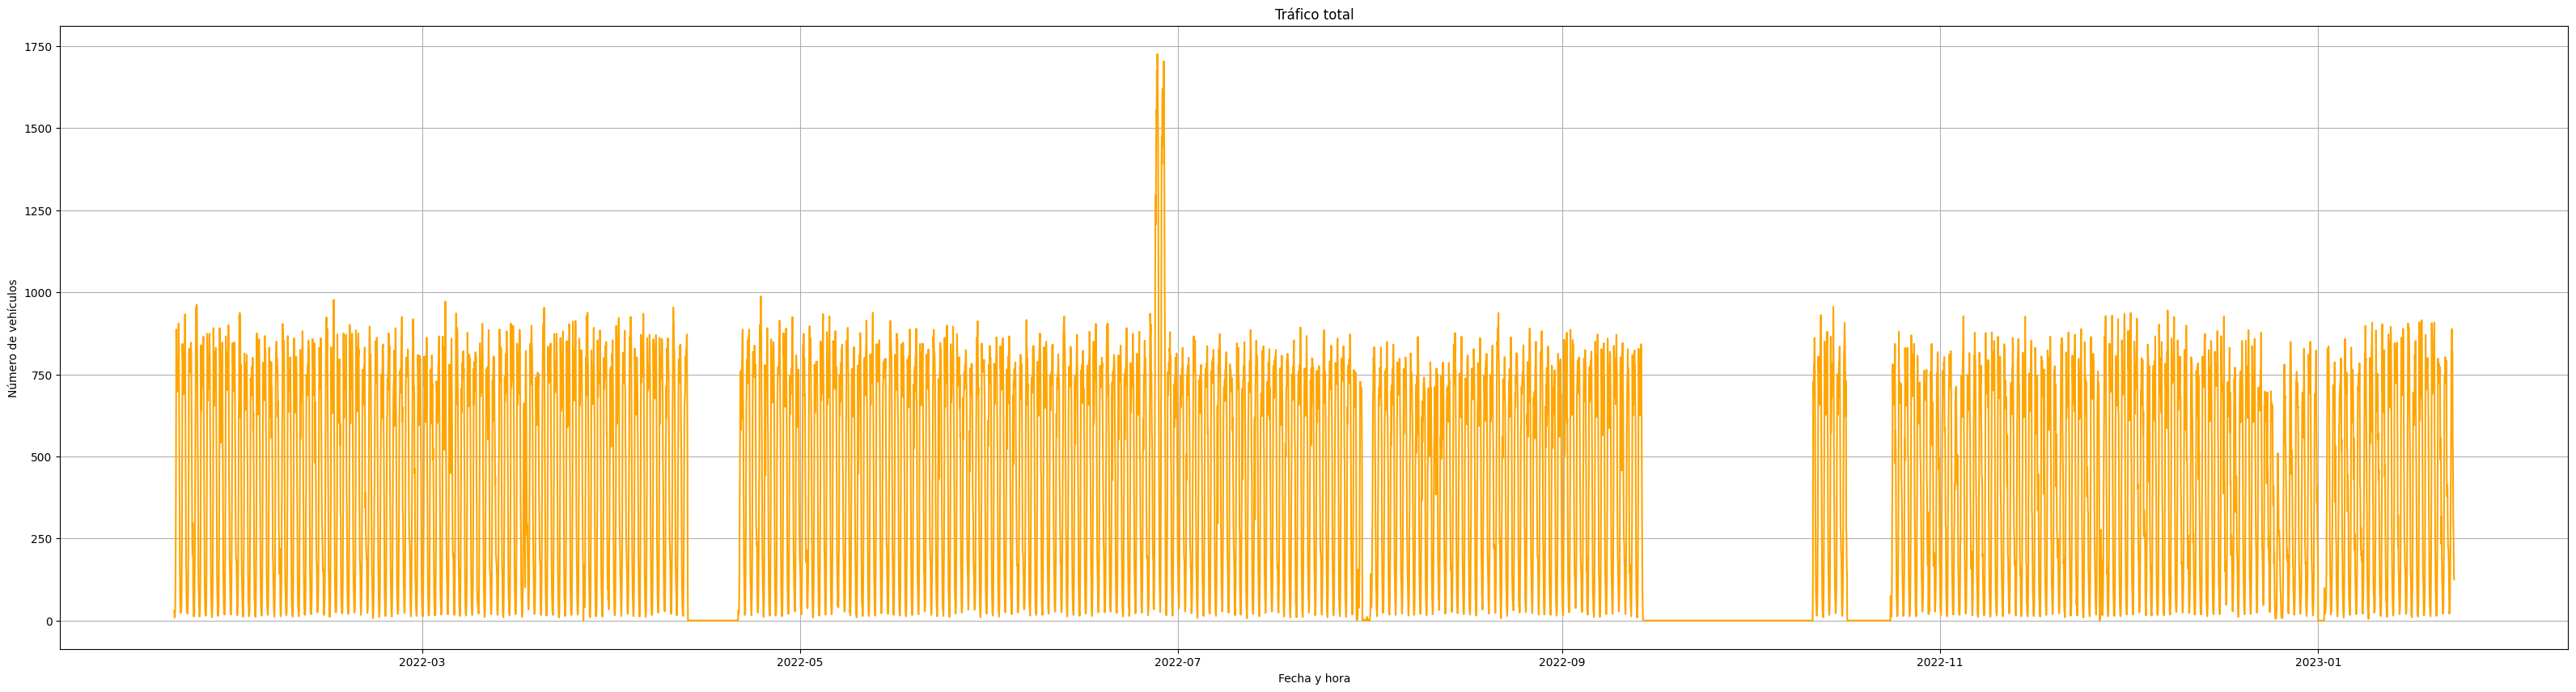

In [ ]:
# Agrupar por hora (suma de vehículos en cada hora)
df_road_traffic_hourly = df_road_traffic['Total'].resample('h').sum()

# Graficar
plt.figure(figsize=(40,10))
plt.plot(df_road_traffic_hourly.index, df_road_traffic_hourly, color='orange')
plt.title('Tráfico total')
plt.xlabel('Fecha y hora')
plt.ylabel('Número de vehículos')
plt.grid(True)
plt.show()

Graficar por semana

<Axes: title={'center': 'Tráfico semanal total'}, xlabel='Timestamp'>

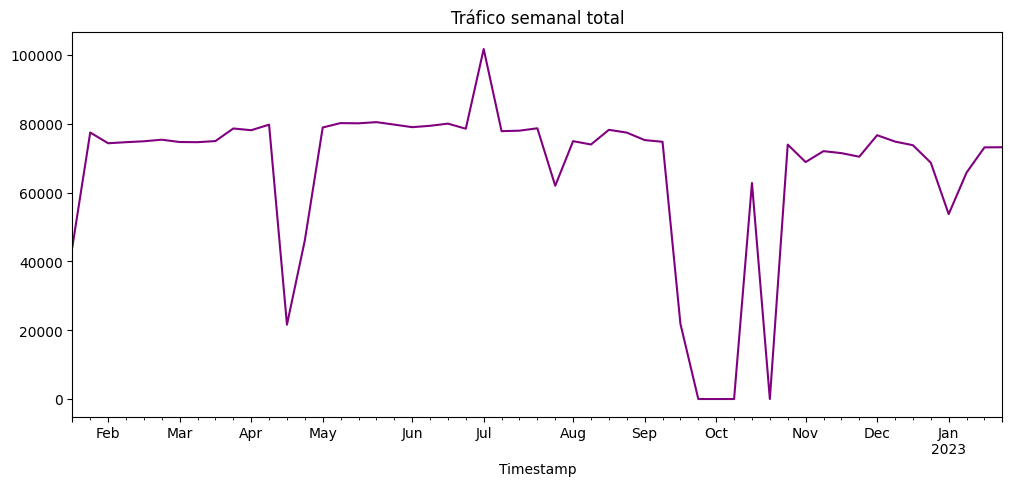

In [ ]:
# Tráfico total por semana (suma de cada semana)
df_weekly = df_road_traffic['Total'].resample('W').sum()
df_weekly.plot(figsize=(12,5), color='purple', title='Tráfico semanal total')

<Axes: title={'center': 'Tráfico diario total'}, xlabel='Timestamp'>

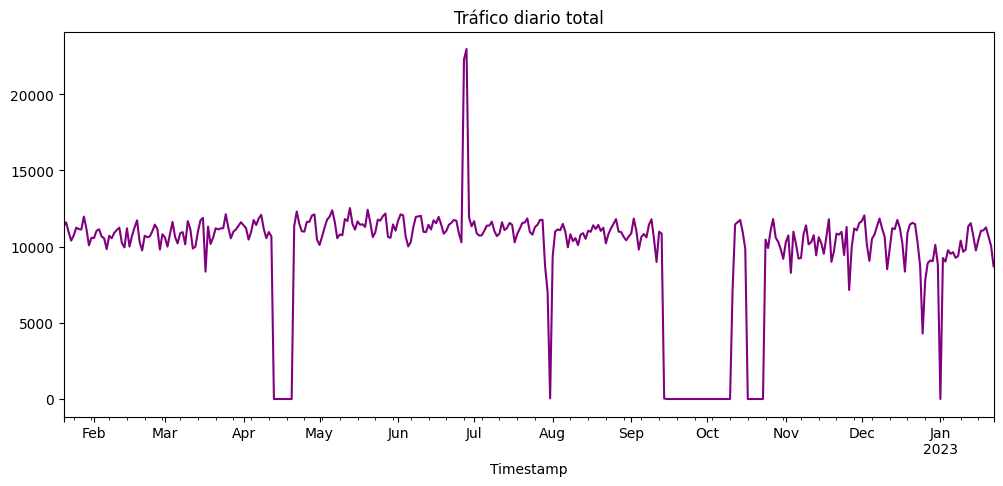

In [ ]:
# Tráfico total por dia (suma de cada semana)
df_daily = df_road_traffic['Total'].resample('D').sum()
df_daily.plot(figsize=(12,5), color='purple', title='Tráfico diario total')

Lo que se observa de forma clara es que existen momentos en los que no hay datos. Esto hay que corregirlo para que no afecte de forma negativa a las predicciones.

In [ ]:
df_daily = df_daily.interpolate()

Descomposición estacional
1. Diaria
2. Semanal

Ver tendencias con **mayor granularidad**.

Graficar total de vehículos por fecha y hora de Enero de 2022.

/tmp/ipython-input-3059574144.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_january_hourly = df_january['Total'].resample('H').sum()


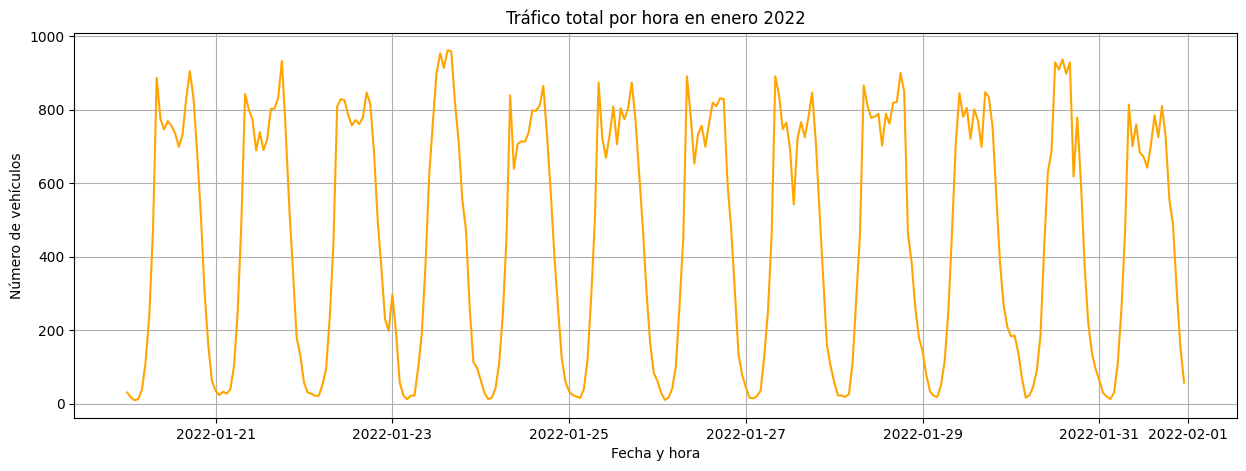

In [ ]:
# Filtrar enero 2022 (resample por hora)
# Cada punto representa la suma de vehículos dentro de cada hora.
df_january = df_road_traffic['2022-01-01':'2022-01-31']

# Agrupar por hora (suma de vehículos en cada hora)
df_january_hourly = df_january['Total'].resample('H').sum()

# Graficar
plt.figure(figsize=(15,5))
plt.plot(df_january_hourly.index, df_january_hourly, color='orange')
plt.title('Tráfico total por hora en enero 2022')
plt.xlabel('Fecha y hora')
plt.ylabel('Número de vehículos')
plt.grid(True)
plt.show()

Graficar el tráfico durante Enero de 2022.

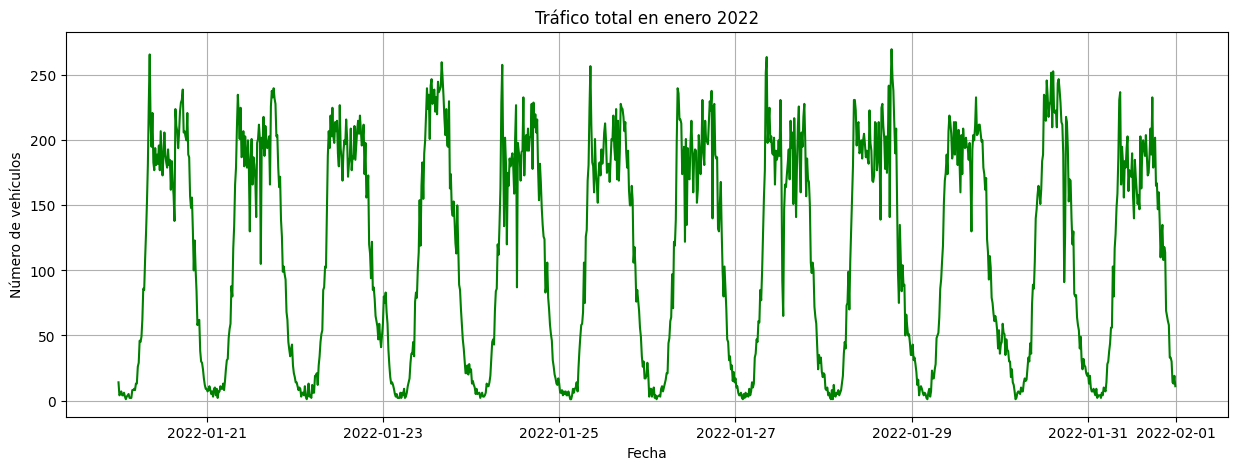

In [ ]:
# Enero 2022 (sin resample)
# Cada punto representa un registro original, es decir, cada 15 minutos.
df_january = df_road_traffic['2022-01-01':'2022-01-31']

plt.figure(figsize=(15,5))
plt.plot(df_january.index, df_january['Total'], color='green')
plt.title('Tráfico total en enero 2022')
plt.xlabel('Fecha')
plt.ylabel('Número de vehículos')
plt.grid(True)
plt.show()

### 3.4. Exploración y visualización básica

count    8832.000000
mean      398.689425
std       326.832187
min         0.000000
25%        48.000000
50%       388.000000
75%       724.000000
max      1726.000000
Name: Total, dtype: float64

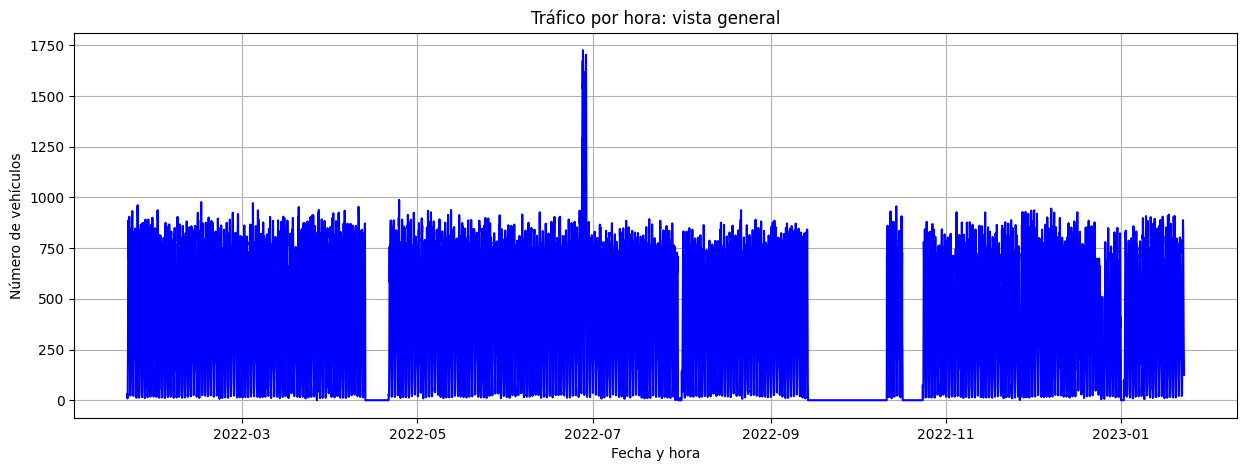

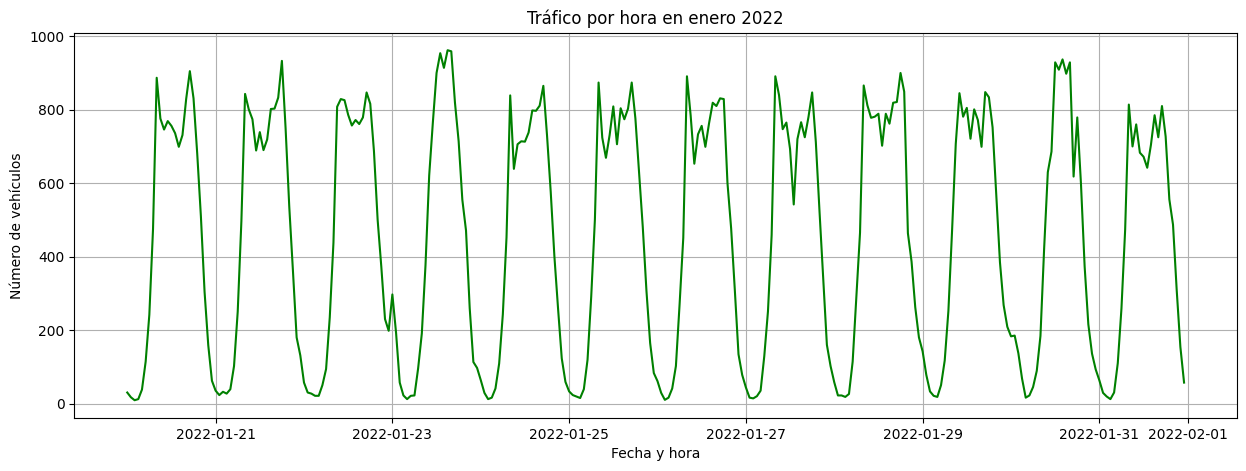

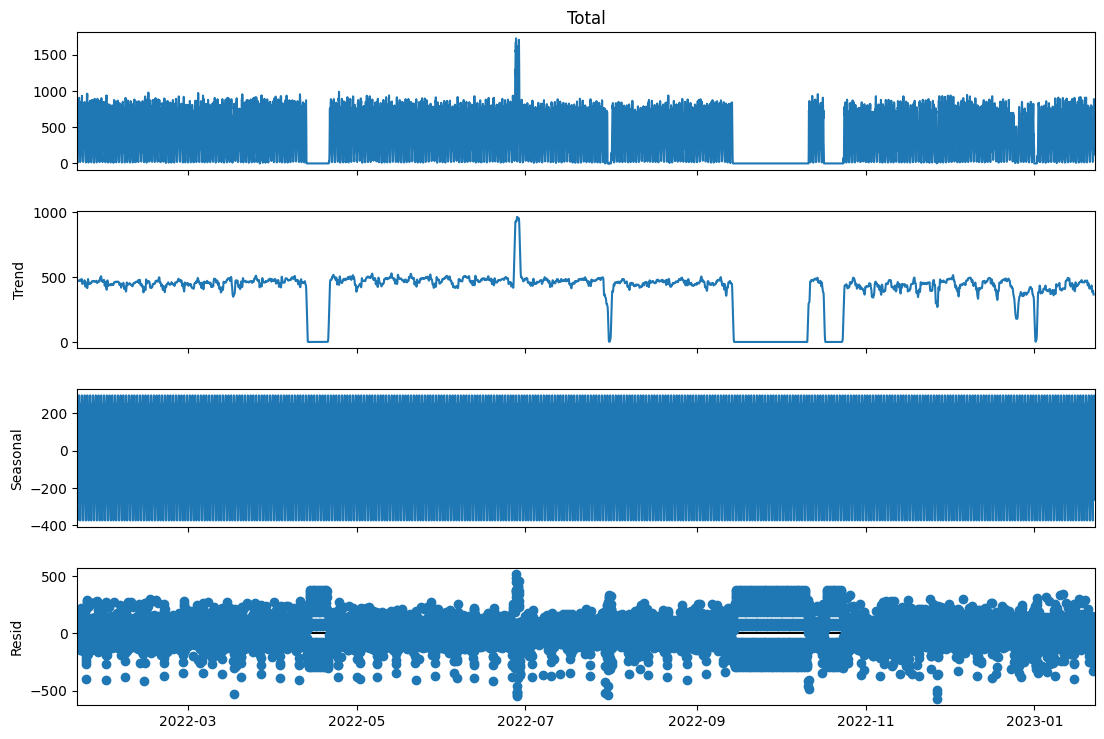

NaN en serie original: 0
NaN en serie interpolada: 0


In [ ]:
# Estadísticos generales de la serie por hora
df_hourly = df_road_traffic['Total'].resample('h').sum()
display(df_hourly.describe())

# Primer gráfico rápido de la serie completa
plt.figure(figsize=(15,5))
plt.plot(df_hourly.index, df_hourly, color='blue')
plt.title('Tráfico por hora: vista general')
plt.xlabel('Fecha y hora')
plt.ylabel('Número de vehículos')
plt.grid(True)
plt.show()

# Recorte temporal para un tramo específico (Enero 2022)
df_january_hourly = df_hourly['2022-01-01':'2022-01-31']
plt.figure(figsize=(15,5))
plt.plot(df_january_hourly.index, df_january_hourly, color='green')
plt.title('Tráfico por hora en enero 2022')
plt.xlabel('Fecha y hora')
plt.ylabel('Número de vehículos')
plt.grid(True)
plt.show()

# Interpolación de valores faltantes
df_hourly_interp = df_hourly.copy()
df_hourly_interp = df_hourly_interp.interpolate(method='linear', limit_direction='both')

# Descomposición estacional simple
# period=24 para capturar patrón diario (24 horas)
decomp = seasonal_decompose(df_hourly_interp, model='additive', period=24)

# Crear figura y ajustar tamaño
fig = decomp.plot()
fig.set_size_inches(12,8)
plt.show()

# Comprobación de NaN antes/después
print("NaN en serie original:", df_hourly.isna().sum())
print("NaN en serie interpolada:", df_hourly_interp.isna().sum())

### 3.5. Valores ausentes y atípicos

In [ ]:
# Conteo de nulos despues de agrupar por horas, ya que pueden aparecer NaN
# en horas completas si en esa hora no hay ningun dato original
df_hourly = df_road_traffic['Total'].resample('h').sum()
display(df_hourly.isna().sum())

0

No existen valores nulos en la serie temporal.

In [ ]:
# Detección de atípicos con IQR
# IQR sobre la Series
q1 = df_hourly.quantile(0.25)
q3 = df_hourly.quantile(0.75)
iqr = q3 - q1

lim_inf = q1 - 0.5 * iqr
lim_sup = q3 + 0.5 * iqr

outliers = df_hourly[(df_hourly < lim_inf) | (df_hourly > lim_sup)]

print("Número de outliers:", len(outliers))
print("Límite inferior:", lim_inf)
print("Límite superior:", lim_sup)

Número de outliers: 26
Límite inferior: -290.0
Límite superior: 1062.0


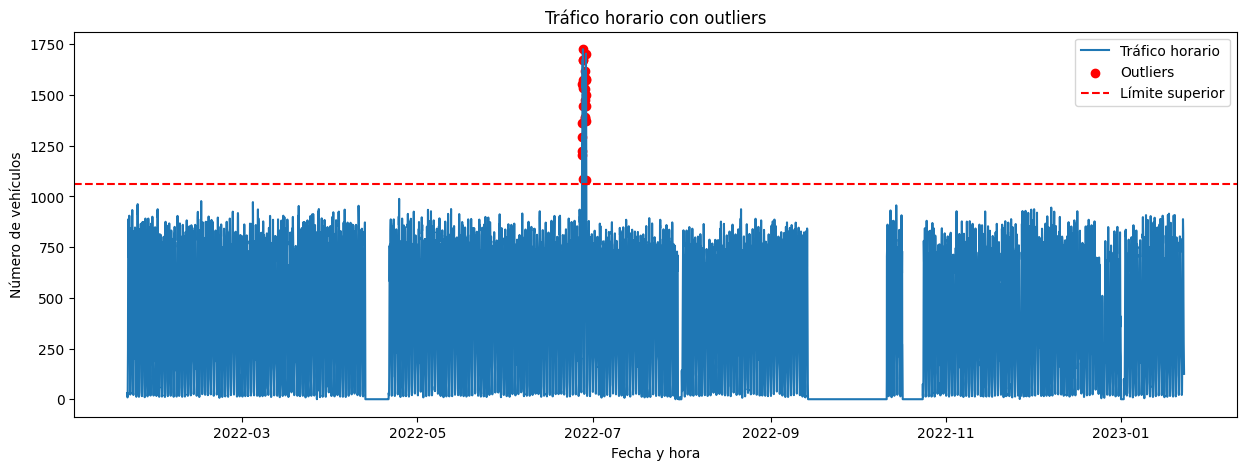

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(df_hourly.index, df_hourly, label='Tráfico horario')
plt.scatter(outliers.index, outliers, color='red', label='Outliers')
plt.axhline(1062, color='red', linestyle='--', label='Límite superior')
plt.title('Tráfico horario con outliers')
plt.xlabel('Fecha y hora')
plt.ylabel('Número de vehículos')
plt.legend()
plt.show()

La serie horaria de tráfico muestra patrones diarios claros con horas punta y baja circulación, y 26 horas se identificaron como outliers con tráfico excepcionalmente alto.

In [ ]:
# === 3.5.x Preparación robusta para modelado ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 0) Asegurar índice temporal y orden
df_road_traffic = df_road_traffic.sort_index()
df_road_traffic.index = pd.to_datetime(df_road_traffic.index)

# 1) Serie HORARIA sin “inventar ceros” en huecos (ojo a min_count=1)
df_hourly = df_road_traffic['Total'].resample('H').sum(min_count=1)

print("Rango:", df_hourly.index.min(), "→", df_hourly.index.max())
print("NaN tras resample (esperado si hay huecos):", int(df_hourly.isna().sum()))

# 2) Reindex explícito (malla completa) para garantizar horas continuas
full_index = pd.date_range(df_hourly.index.min(), df_hourly.index.max(), freq='H')
y = df_hourly.reindex(full_index)     # y será nuestra serie principal
y.name = 'Total'
print("NaN tras reindex:", int(y.isna().sum()))


Rango: 2022-01-20 00:00:00 → 2023-01-22 23:00:00
NaN tras resample (esperado si hay huecos): 1058
NaN tras reindex: 1058


/tmp/ipython-input-1880122172.py:11: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df_road_traffic['Total'].resample('H').sum(min_count=1)
/tmp/ipython-input-1880122172.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_index = pd.date_range(df_hourly.index.min(), df_hourly.index.max(), freq='H')


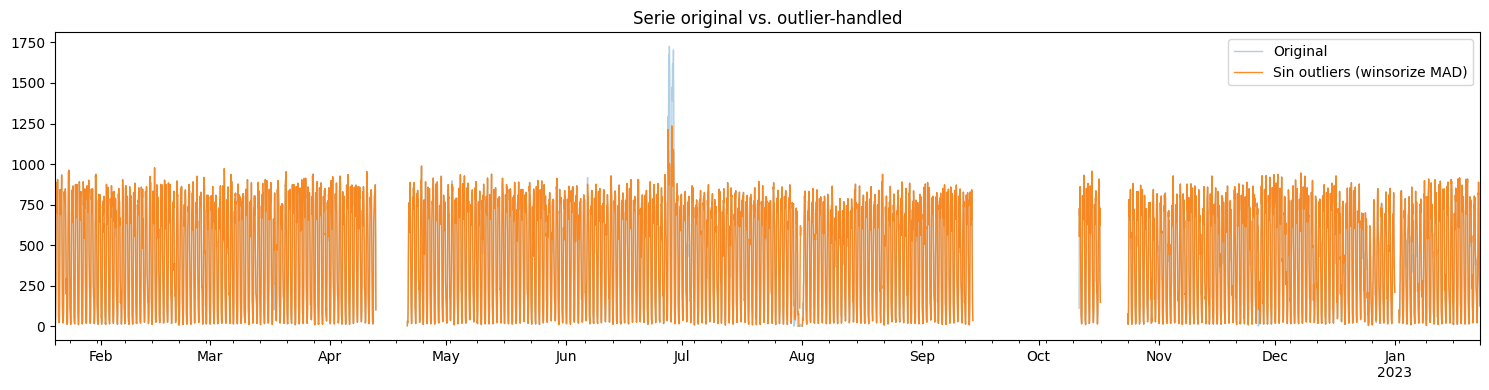

In [ ]:
# --- Función winsorize basada en mediana y MAD (robusta) ---
def winsorize_mad(s, k=3.5):
    m = s.median()
    mad = (s - m).abs().median()
    if pd.isna(mad) or mad == 0:
        return s
    lo, hi = m - k*1.4826*mad, m + k*1.4826*mad
    return s.clip(lower=lo, upper=hi)

# Agrupamos por patrón estacional (dow × hour) y recortamos outliers
dow = y.index.dayofweek
hr  = y.index.hour
grp = pd.MultiIndex.from_arrays([dow, hr], names=['dow','hour'])

y_no = y.groupby(grp).transform(winsorize_mad)

# Visual rápido (opcional)
plt.figure(figsize=(15,4))
y.plot(alpha=0.35, label='Original', lw=1)
y_no.plot(alpha=0.9, label='Sin outliers (winsorize MAD)', lw=1)
plt.title('Serie original vs. outlier-handled')
plt.legend(); plt.tight_layout(); plt.show()


In [ ]:
# Interpolación temporal limitada a rachas de NaN de hasta 24 horas
y_small = (y_no
           .interpolate(method='time', limit=24)  # rellena tiras de NaN de longitud <= 24
           .fillna(y_no.shift(1).rolling(24,  min_periods=1).mean())
           .fillna(y_no.shift(1).rolling(168, min_periods=1).mean()))
print("NaN tras imputar huecos pequeños:", int(y_small.isna().sum()))


NaN tras imputar huecos pequeños: 516


Racha elegida (antes de corte): 2022-04-21 00:00:00 → 2022-09-21 00:00:00  (3673 puntos)
Corte aplicado dentro del tramo: hasta 2022-09-13 23:59:59.999999
Puntos en el tramo cortado: 3504


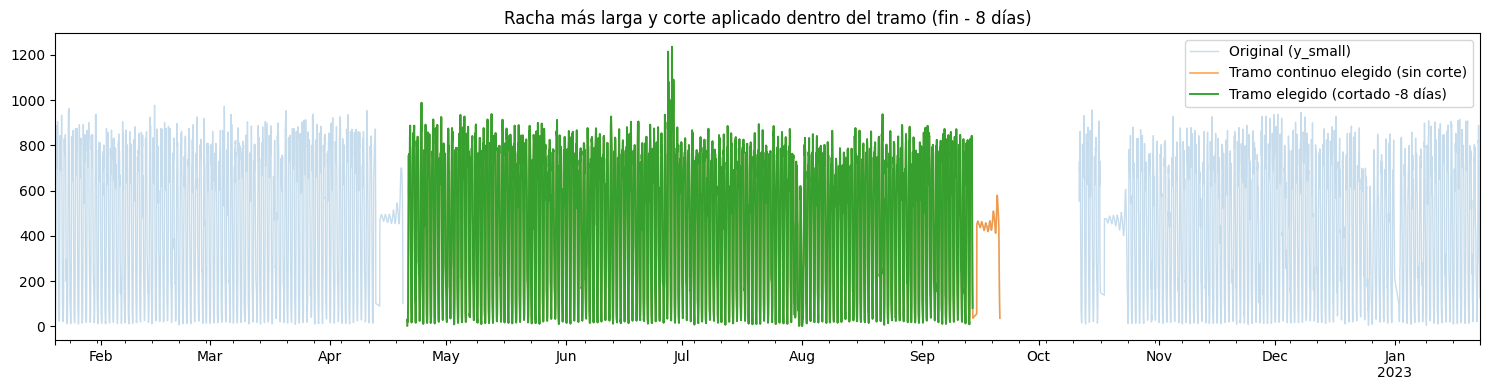

In [ ]:
# --- 0) Racha más larga en TODA la serie (sin cortar lo original) ---
mask = y_small.notna()
starts = (mask.ne(mask.shift(fill_value=False)) & mask)
grp_id = starts.cumsum()

g = y_small[mask].groupby(grp_id[mask])
runs = pd.DataFrame({
    'start': g.apply(lambda s: s.index[0]),
    'end'  : g.apply(lambda s: s.index[-1]),
    'len'  : g.size()
}).reset_index(drop=True)

if runs.empty:
    raise ValueError("No hay rachas sin NaN en y_small.")

best = runs.sort_values(by='len', ascending=False).iloc[0]
start_best, end_best, best_len = best['start'], best['end'], int(best['len'])

tramo = y_small.loc[start_best:end_best].copy()

# --- 1) Cortar el TRAMO ELEGIDO: fin_tramo - 8 días ---
if not isinstance(tramo.index, pd.DatetimeIndex):
    raise TypeError("El índice debe ser DatetimeIndex para restar días.")

# Si quieres quitar 2 días completos desde el final del tramo:
cutoff_tramo = (end_best.normalize() - pd.Timedelta(days=8)) + pd.Timedelta(days=1) - pd.Timedelta(microseconds=1)
# Alternativa (exactamente 48h atrás desde la última muestra de la racha):
# cutoff_tramo = end_best - pd.Timedelta(days=2)

# Si el tramo es demasiado corto y el cutoff se va antes del inicio, avisamos y no cortamos.
if cutoff_tramo <= start_best:
    print("Aviso: la racha es más corta que 2 días; no se aplica corte.")
    tramo_cortado = tramo
else:
    tramo_cortado = tramo.loc[:cutoff_tramo].copy()

print(f"Racha elegida (antes de corte): {start_best} → {end_best}  ({best_len} puntos)")
print(f"Corte aplicado dentro del tramo: hasta {cutoff_tramo}")
print("Puntos en el tramo cortado:", len(tramo_cortado))

# --- 2) Visual ---
plt.figure(figsize=(15,4))
y_small.plot(alpha=0.25, label='Original (y_small)', lw=1)
tramo.plot(alpha=0.7, label='Tramo continuo elegido (sin corte)', lw=1.2)
tramo_cortado.plot(alpha=0.95, label='Tramo elegido (cortado -8 días)', lw=1.4)
plt.title('Racha más larga y corte aplicado dentro del tramo (fin - 8 días)')
plt.legend(); plt.tight_layout(); plt.show()

In [ ]:
tramo_sel = tramo_cortado.copy()

In [ ]:
tramo_sel.head()

2022-04-21 00:00:00     3.0
2022-04-21 01:00:00    31.0
2022-04-21 02:00:00    22.0
2022-04-21 03:00:00    20.0
2022-04-21 04:00:00    47.0
Freq: h, Name: Total, dtype: float64

### 3.6. Normalización y Estandarización

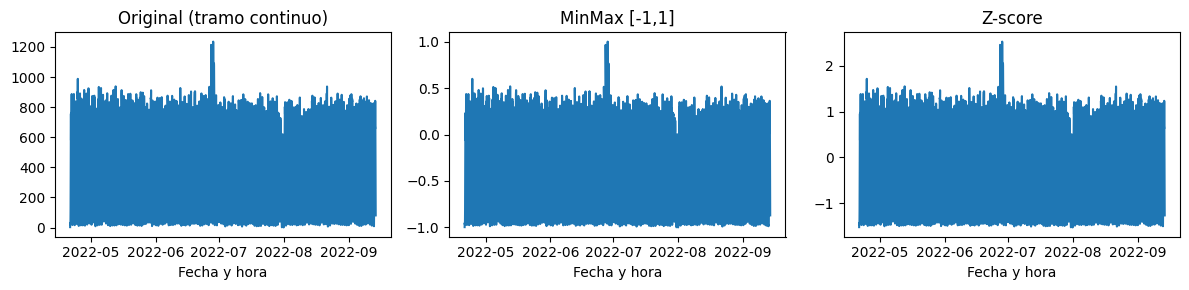

Total  Total_normalizado  Total_estandarizado
count  3504.000000        3504.000000         3.504000e+03
mean    465.992190          -0.246469         9.733462e-17
std     304.857008           0.494028         1.000143e+00
min       1.000000          -1.000000        -1.525497e+00
25%     130.750000          -0.789737        -1.099827e+00
50%     552.000000          -0.107091         2.821654e-01
75%     747.000000           0.208912         9.219008e-01
max    1235.168050           1.000000         2.523431e+00

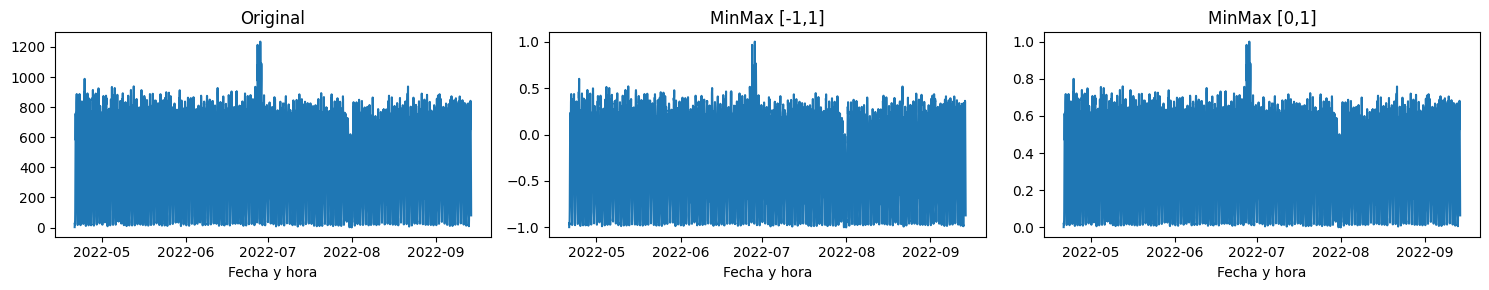

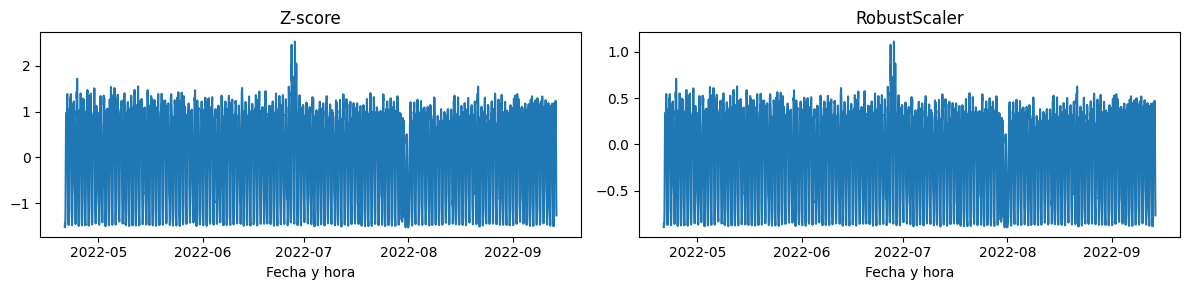

Total  Total_estandarizado  Total_estandarizado_robusto
count  3504.000000         3.504000e+03                  3504.000000
mean    465.992190         9.733462e-17                    -0.139566
std     304.857008         1.000143e+00                     0.494697
min       1.000000        -1.525497e+00                    -0.894118
25%     130.750000        -1.099827e+00                    -0.683570
50%     552.000000         2.821654e-01                     0.000000
75%     747.000000         9.219008e-01                     0.316430
max    1235.168050         2.523431e+00                     1.108589

In [ ]:
# === 3.6 Normalización y Estandarización (usando SOLO el tramo continuo) ===
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
import matplotlib.pyplot as plt

# 1) Base: serie continua y limpia
y = tramo_cortado.copy()
y.name = 'Total'

# DataFrame solo del tramo continuo
df_hourly_copy = y.to_frame()
columna = 'Total'

# 2) Escalados
scaler_minmax_0_1 = MinMaxScaler(feature_range=(0, 1))
df_hourly_copy['Total_normalizado_0_1'] = scaler_minmax_0_1.fit_transform(df_hourly_copy[[columna]])

scaler_minmax = MinMaxScaler(feature_range=(-1, 1))
df_hourly_copy['Total_normalizado'] = scaler_minmax.fit_transform(df_hourly_copy[[columna]])

scaler_std = StandardScaler()
df_hourly_copy['Total_estandarizado'] = scaler_std.fit_transform(df_hourly_copy[[columna]])

scaler_robust = RobustScaler()
df_hourly_copy['Total_estandarizado_robusto'] = scaler_robust.fit_transform(df_hourly_copy[[columna]])

# 3) Plots rápidos (x = índice datetime del tramo continuo)
fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharex=True)
axes[0].plot(df_hourly_copy.index, df_hourly_copy[columna]);                 axes[0].set_title('Original (tramo continuo)')
axes[1].plot(df_hourly_copy.index, df_hourly_copy['Total_normalizado']);     axes[1].set_title('MinMax [-1,1]')
axes[2].plot(df_hourly_copy.index, df_hourly_copy['Total_estandarizado']);   axes[2].set_title('Z-score')
for ax in axes: ax.set_xlabel('Fecha y hora')
plt.tight_layout(); plt.show()

# Comparación numérica
from IPython.display import display
display(df_hourly_copy[[columna, 'Total_normalizado', 'Total_estandarizado']].describe())

# MinMax [-1,1] vs [0,1]
fig, axes = plt.subplots(1, 3, figsize=(15, 3), sharex=True)
axes[0].plot(df_hourly_copy.index, df_hourly_copy[columna]);                     axes[0].set_title('Original')
axes[1].plot(df_hourly_copy.index, df_hourly_copy['Total_normalizado']);         axes[1].set_title('MinMax [-1,1]')
axes[2].plot(df_hourly_copy.index, df_hourly_copy['Total_normalizado_0_1']);    axes[2].set_title('MinMax [0,1]')
for ax in axes: ax.set_xlabel('Fecha y hora')
plt.tight_layout(); plt.show()

# Z-score vs Robust
fig, axes = plt.subplots(1, 2, figsize=(12, 3), sharex=True)
axes[0].plot(df_hourly_copy.index, df_hourly_copy['Total_estandarizado']);         axes[0].set_title('Z-score')
axes[1].plot(df_hourly_copy.index, df_hourly_copy['Total_estandarizado_robusto']); axes[1].set_title('RobustScaler')
for ax in axes: ax.set_xlabel('Fecha y hora')
plt.tight_layout(); plt.show()

display(df_hourly_copy[[columna, 'Total_estandarizado', 'Total_estandarizado_robusto']].describe())



**Procedimiento:**
1. Se toma el tramo continuo limpio (`tramo_cortado`) como base (`y`).
2. Se aplican distintos métodos de escalado:
   - *MinMax (0–1)* → comprime entre 0 y 1.
   - *MinMax (−1, 1)* → centra alrededor de 0.
   - *StandardScaler* (Z-score) → media = 0, desviación = 1.
   - *RobustScaler* → usa mediana e IQR, menos sensible a picos.
3. Se comparan visual y numéricamente los resultados.
4. Se observa que **RobustScaler** mantiene mejor la estructura frente a valores extremos.

**Resultado:** la serie conserva su forma temporal pero está re-escalada; esto servirá más adelante para alimentar modelos sensibles a la escala (como LSTM o regresiones).

La normalización y estandarización depende de los modelos que se elegirán para realizar, ya que:

*    Redes neuronales (LSTM, GRU, RNN) ->MinMax [-1,1] o [0,1]

  Escalado a rango pequeño ayuda a que la red aprenda más rápido.
    
  [0,1] es más estándar, [-1,1] a veces funciona mejor si la activación es tanh.

*   Modelos estadísticos (ARIMA, SARIMA, regresión) ->Z-score o robusto

  Centran los datos en 0, lo que facilita el cálculo de tendencias y residuos.

  RobustScaler es útil si tienes outliers fuertes y quieres que no afecten demasiado la escala.

### 3.7. Ingeniería de lags

In [ ]:
# Función para generar lags
def generar_atributos_desfase(ts_data, var, max_lag):
    """
    Crea columnas var_lag1, var_lag2, ..., var_lag{k} con shift(t).
    ts_data: DataFrame con índice temporal
    var:     nombre de la columna base (p.ej., 'Total')
    max_lag: número máximo de retardos
    """
    for t in range(1, max_lag + 1):
        ts_data[f'{var}_lag{t}'] = ts_data[var].shift(t)
    return ts_data

Se optará por usar 48 lags para capturar el tráfico de las últimas 48h.

In [ ]:
df_hourly_copia = df_hourly.copy()
columna = 'Total'

df_hourly_copia = df_hourly.to_frame()
df_hourly_copia.reset_index(inplace=True)

# Crear lags de las últimas 48 horas
df_hourly_lags = generar_atributos_desfase(df_hourly_copia, 'Total', max_lag=48)

In [ ]:
# Ver los ultimos datos
display(df_hourly_lags.tail(10))

Timestamp  Total  Total_lag1  Total_lag2  Total_lag3  \
8822 2023-01-22 14:00:00  888.0       812.0       821.0       603.0   
8823 2023-01-22 15:00:00  829.0       888.0       812.0       821.0   
8824 2023-01-22 16:00:00  818.0       829.0       888.0       812.0   
8825 2023-01-22 17:00:00  553.0       818.0       829.0       888.0   
8826 2023-01-22 18:00:00  490.0       553.0       818.0       829.0   
8827 2023-01-22 19:00:00  307.0       490.0       553.0       818.0   
8828 2023-01-22 20:00:00  279.0       307.0       490.0       553.0   
8829 2023-01-22 21:00:00  214.0       279.0       307.0       490.0   
8830 2023-01-22 22:00:00  128.0       214.0       279.0       307.0   
8831 2023-01-22 23:00:00  125.0       128.0       214.0       279.0   

      Total_lag4  Total_lag5  Total_lag6  Total_lag7  Total_lag8  ...  \
8822       455.0       327.0       197.0       103.0        35.0  ...   
8823       603.0       455.0       327.0       197.0       103.0  ...   
8824       821.0       603.0       455.0       327.0       197.0  ...   
8825       812.0       821.0       603.0       455.0       327.0  ...   
8826       888.0       812.0       821.0       603.0       455.0  ...   
8827       829.0       888.0       812.0       821.0       603.0  ...   
8828       818.0       829.0       888.0       812.0       821.0  ...   
8829       553.0       818.0       829.0       888.0       812.0  ...   
8830       490.0       553.0       818.0       829.0       888.0  ...   
8831       307.0       490.0       553.0       818.0       829.0  ...   

      Total_lag39  Total_lag40  Total_lag41  Total_lag42  Total_lag43  \
8822        197.0        318.0        233.0        429.0        558.0   
8823        119.0        197.0        318.0        233.0        429.0   
8824        104.0        119.0        197.0        318.0        233.0   
8825         46.0        104.0        119.0        197.0        318.0   
8826         21.0         46.0        104.0        119.0        197.0   
8827         22.0         21.0         46.0        104.0        119.0   
8828         45.0         22.0         21.0         46.0        104.0   
8829        113.0         45.0         22.0         21.0         46.0   
8830        210.0        113.0         45.0         22.0         21.0   
8831        444.0        210.0        113.0         45.0         22.0   

      Total_lag44  Total_lag45  Total_lag46  Total_lag47  Total_lag48  
8822        517.0        491.0        772.0        738.0        744.0  
8823        558.0        517.0        491.0        772.0        738.0  
8824        429.0        558.0        517.0        491.0        772.0  
8825        233.0        429.0        558.0        517.0        491.0  
8826        318.0        233.0        429.0        558.0        517.0  
8827        197.0        318.0        233.0        429.0        558.0  
8828        119.0        197.0        318.0        233.0        429.0  
8829        104.0        119.0        197.0        318.0        233.0  
8830         46.0        104.0        119.0        197.0        318.0  
8831         21.0         46.0        104.0        119.0        197.0  

[10 rows x 50 columns]

Ver la correlación de los lags.

In [ ]:
lags_cols = [c for c in df_hourly_lags.columns if c.startswith('Total_lag')]
corr = df_hourly_lags[['Total'] + lags_cols].dropna().corr()['Total'].sort_values(ascending=False)
display(corr)

Total          1.000000
Total_lag1     0.924578
Total_lag24    0.916080
Total_lag25    0.873828
Total_lag48    0.873741
Total_lag23    0.859677
Total_lag47    0.827190
Total_lag2     0.788917
Total_lag26    0.760332
Total_lag22    0.740808
Total_lag46    0.718619
Total_lag3     0.607405
Total_lag27    0.596172
Total_lag21    0.576945
Total_lag45    0.563438
Total_lag28    0.399128
Total_lag4     0.398252
Total_lag20    0.385037
Total_lag44    0.378880
Total_lag29    0.188482
Total_lag5     0.181841
Total_lag19    0.181663
Total_lag43    0.179792
Total_lag42   -0.018685
Total_lag18   -0.020149
Total_lag30   -0.021210
Total_lag6    -0.028504
Total_lag41   -0.212895
Total_lag17   -0.214569
Total_lag31   -0.223435
Total_lag7    -0.228498
Total_lag16   -0.394439
Total_lag40   -0.394831
Total_lag32   -0.410567
Total_lag8    -0.410597
Total_lag15   -0.549794
Total_lag39   -0.554982
Total_lag9    -0.565876
Total_lag33   -0.571808
Total_lag14   -0.673784
Total_lag38   -0.684581
Total_lag10   -0.685171
Total_lag34   -0.696808
Total_lag13   -0.755235
Total_lag11   -0.760881
Total_lag37   -0.769345
Total_lag35   -0.775453
Total_lag12   -0.785768
Total_lag36   -0.801542
Name: Total, dtype: float64

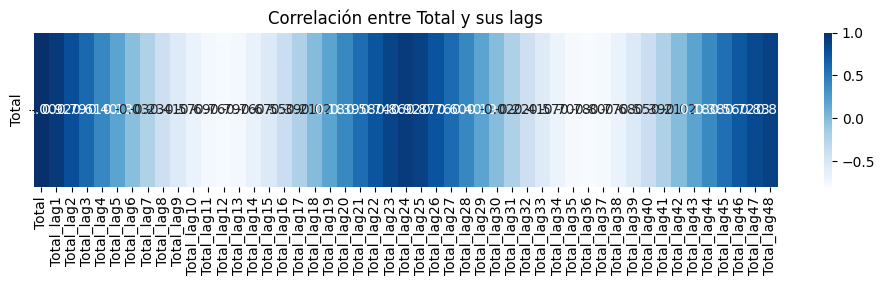

In [ ]:
plt.figure(figsize=(12, 2))
sns.heatmap(
    df_hourly_lags[['Total'] + lags_cols].dropna().corr()[['Total']].T,
    annot=True, cmap='Blues', fmt=".2f"
)
plt.title('Correlación entre Total y sus lags')
plt.show()

Se generan variables rezagadas (lags) para que el modelo capture dependencias temporales.
En el caso del tráfico, existe una alta autocorrelación horaria (lag 1–6) y diaria (lag 24),
lo que indica patrones de repetición a corto y mediano plazo.

Conclusiones:


*   **Primeros lags (recientes)**: reflejan las últimas horas y suelen tener alta correlación porque el tráfico reciente influye mucho en el actual.
*   **Últimos lags (lejanos, ~24 h)**: capturan la estacionalidad diaria, mostrando alta correlación con el mismo horario de días anteriores
*   **Lags intermedios**: menos correlación, ya que no son ni recientes ni coinciden con el patrón diario.



### 3.8. Venatanas deslizantes

In [ ]:
df_hourly_window = df_hourly_copy.copy()
# df_hourly_window = df_hourly_copy.to_frame() # Removed this line
df_hourly_window.reset_index(inplace=True)

# Media móvil de las últimas 3 y 6 horas
df_hourly_window['media_movil_3h'] = df_hourly_window['Total'].shift(1).rolling(window=3).mean()
df_hourly_window['media_movil_6h'] = df_hourly_window['Total'].shift(1).rolling(window=6).mean()

# Máximo, mínimo y desviación de las últimas 3 horas
df_hourly_window['max_movil_3h'] = df_hourly_window['Total'].shift(1).rolling(window=3).max()
df_hourly_window['min_movil_3h'] = df_hourly_window['Total'].shift(1).rolling(window=3).min()
df_hourly_window['std_movil_3h'] = df_hourly_window['Total'].shift(1).rolling(window=3).std()

Gráfico

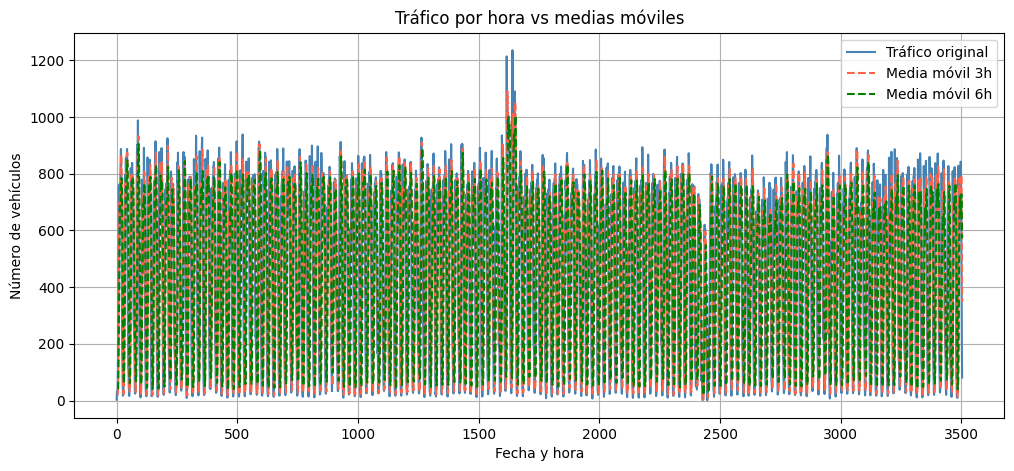

In [ ]:
# Comparación visual: serie original vs media móvil (3h)
ax = df_hourly_window['Total'].plot(label='Tráfico original', color='steelblue', figsize=(12,5))
df_hourly_window['media_movil_3h'].plot(ax=ax, label='Media móvil 3h', color='tomato', linestyle='--')
df_hourly_window['media_movil_6h'].plot(ax=ax, label='Media móvil 6h', color='green', linestyle='--')

ax.set_title('Tráfico por hora vs medias móviles')
ax.set_xlabel('Fecha y hora')
ax.set_ylabel('Número de vehículos')
ax.legend()
plt.grid(True)
plt.show()

### 3.9. Ventanas ampliadas

Total  media_acum  suma_acum  max_acum    std_acum  min_acum
0    3.0         NaN        NaN       NaN         NaN       NaN
1   31.0    3.000000        3.0       3.0         NaN       3.0
2   22.0   17.000000       34.0      31.0   19.798990       3.0
3   20.0   18.666667       56.0      31.0   14.294521       3.0
4   47.0   19.000000       76.0      31.0   11.690452       3.0
5  113.0   24.600000      123.0      47.0   16.102795       3.0
6  268.0   39.333333      236.0     113.0   38.857003       3.0
7  414.0   72.000000      504.0     268.0   93.423766       3.0
8  613.0  114.750000      918.0     414.0  148.666213       3.0
9  756.0  170.111111     1531.0     613.0  216.616276       3.0

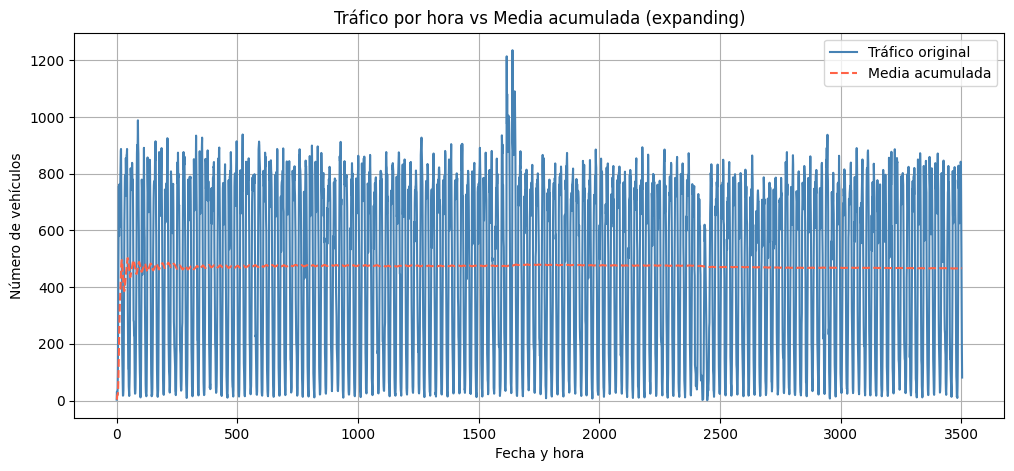

In [ ]:
# DataFrame con tráfico por hora (df_hourly_window de ejemplo)
df_hourly_exp = df_hourly_window.copy()  # copia para no modificar original
columna = 'Total'

# 1) Estadísticas acumuladas (memoria creciente) con shift(1)
df_hourly_exp['media_acum'] = df_hourly_exp[columna].shift(1).expanding().mean()
df_hourly_exp['suma_acum']  = df_hourly_exp[columna].shift(1).expanding().sum()
df_hourly_exp['max_acum']   = df_hourly_exp[columna].shift(1).expanding().max()
df_hourly_exp['std_acum']   = df_hourly_exp[columna].shift(1).expanding().std()

# 2) Extra robusto: mínimo acumulado y cuartil 25% acumulado
df_hourly_exp['min_acum'] = df_hourly_exp[columna].shift(1).expanding().min()
try:
    df_hourly_exp['q25_acum'] = df_hourly_exp[columna].shift(1).expanding().quantile(0.25)
except Exception as e:
    print('Cuartil acumulado no soportado en esta versión de pandas:', e)

# 3) Vista rápida
display(df_hourly_exp[[columna, 'media_acum', 'suma_acum', 'max_acum', 'std_acum', 'min_acum']].head(10))

# 4) Comparación visual: serie original vs media acumulada
ax = df_hourly_exp[columna].plot(label='Tráfico original', color='steelblue', figsize=(12,5))
df_hourly_exp['media_acum'].plot(ax=ax, label='Media acumulada', color='tomato', linestyle='--')
ax.set_title('Tráfico por hora vs Media acumulada (expanding)')
ax.set_xlabel('Fecha y hora')
ax.set_ylabel('Número de vehículos')
ax.legend()
plt.grid(True)
plt.show()

#### 3.7–3.9 Ingeniería temporal: lags, ventanas deslizantes y ampliadas

**Objetivo:** dotar a los modelos de memoria temporal mediante la creación de variables derivadas del pasado de la serie (`Total`).

**1️⃣ Lags:**  
Se generan variables rezagadas (`Total_lag1`...`Total_lag48`) que representan el tráfico de horas anteriores.  
Esto permite capturar la autocorrelación temporal: los valores actuales dependen fuertemente de los pasados (lag 1 y lag 24 destacan por su alta correlación).

**2️⃣ Ventanas deslizantes:**  
Se calculan medias, máximos y desviaciones sobre ventanas móviles (3h, 6h) para capturar tendencias y suavizar el ruido de corto plazo.  
Ejemplo: congestión media de las últimas 6 horas.

**3️⃣ Ventanas ampliadas (expanding):**  
Se generan estadísticas acumuladas desde el inicio (media, suma, desviación) para medir el comportamiento histórico general.  
Son útiles para detectar cambios de régimen o variaciones de largo plazo.

**Conclusión:**  
Estas transformaciones constituyen la **ingeniería de características temporales** del modelo.  
Combinan memoria a corto plazo (lags, rolling) y contexto global (expanding), mejorando la capacidad predictiva de modelos autoregresivos y de aprendizaje automático.


### 3.10 Creación de variables exógenas (calendario)

In [ ]:
# === (3.10) Creación de variables exógenas (calendario) ===
import numpy as np, pandas as pd
import holidays

# --- Crear base de exógenas con el mismo índice que la serie ---
df_exog = pd.DataFrame(index=y.index)

# Hora y día
df_exog['hour'] = df_exog.index.hour
df_exog['dayofweek'] = df_exog.index.dayofweek
df_exog['is_weekend'] = (df_exog['dayofweek'] >= 5).astype(int)

# --- Festivos de Irlanda ---
ie_holidays = holidays.Ireland(years=[2022, 2023])
df_exog['is_holiday'] = df_exog.index.normalize().isin(ie_holidays).astype(int)

# --- Codificación cíclica (para patrones horarios/semanales) ---
df_exog['hour_sin'] = np.sin(2*np.pi*df_exog['hour']/24)
df_exog['hour_cos'] = np.cos(2*np.pi*df_exog['hour']/24)
df_exog['dow_sin']  = np.sin(2*np.pi*df_exog['dayofweek']/7)
df_exog['dow_cos']  = np.cos(2*np.pi*df_exog['dayofweek']/7)

# --- Vista previa ---
df_exog.head(10)


/tmp/ipython-input-1324673616.py:15: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df_exog['is_holiday'] = df_exog.index.normalize().isin(ie_holidays).astype(int)


hour  dayofweek  is_weekend  is_holiday  hour_sin  \
2022-04-21 00:00:00     0          3           0           0  0.000000   
2022-04-21 01:00:00     1          3           0           0  0.258819   
2022-04-21 02:00:00     2          3           0           0  0.500000   
2022-04-21 03:00:00     3          3           0           0  0.707107   
2022-04-21 04:00:00     4          3           0           0  0.866025   
2022-04-21 05:00:00     5          3           0           0  0.965926   
2022-04-21 06:00:00     6          3           0           0  1.000000   
2022-04-21 07:00:00     7          3           0           0  0.965926   
2022-04-21 08:00:00     8          3           0           0  0.866025   
2022-04-21 09:00:00     9          3           0           0  0.707107   

                         hour_cos   dow_sin   dow_cos  
2022-04-21 00:00:00  1.000000e+00  0.433884 -0.900969  
2022-04-21 01:00:00  9.659258e-01  0.433884 -0.900969  
2022-04-21 02:00:00  8.660254e-01  0.433884 -0.900969  
2022-04-21 03:00:00  7.071068e-01  0.433884 -0.900969  
2022-04-21 04:00:00  5.000000e-01  0.433884 -0.900969  
2022-04-21 05:00:00  2.588190e-01  0.433884 -0.900969  
2022-04-21 06:00:00  6.123234e-17  0.433884 -0.900969  
2022-04-21 07:00:00 -2.588190e-01  0.433884 -0.900969  
2022-04-21 08:00:00 -5.000000e-01  0.433884 -0.900969  
2022-04-21 09:00:00 -7.071068e-01  0.433884 -0.900969

Estas variables ayudan al modelo a reconocer:
- Patrones horarios y semanales (picos de tráfico en horas laborales).  
- Cambios de comportamiento en fines de semana o festivos.  
- Naturaleza cíclica del tiempo (el lunes sigue al domingo, las 23h preceden a las 0h).

**Nota:**  
En esta etapa **solo se construyen las variables exógenas** con el mismo índice temporal que la serie.  
Su uso efectivo se realiza más adelante en los modelos con `exog=df_exog`.


## **4. Estudio estacionariedad**

In [ ]:
# Función ADF
def adf_summary(x, nombre="serie"):
    x = pd.Series(x).dropna()
    stat, p, lags, nobs, crit, _ = adfuller(x, autolag="AIC")
    print(f"ADF — {nombre}")
    print(f"  Estadístico: {stat:.4f}")
    print(f"  p-valor    : {p:.4f}")
    print(f"  Lags usados: {lags}")
    print(f"  N obs      : {nobs}")
    for k, v in crit.items():
        print(f"  Crítico {k}: {v:.4f}")
    if p < 0.05:
        print("  -> Probablemente estacionaria (rechazamos H0 de raíz unitaria).")
    else:
        print("  -> Probablemente NO estacionaria (no rechazamos H0).")
    print()

df_hour = df_hourly_copy.copy()
#df_hour = df_hourly.to_frame()
df_hour.reset_index(inplace=True)
ts = df_hour['Total']

adf_summary(ts, nombre="Tráfico horario")

ADF — Tráfico horario
  Estadístico: -5.4423
  p-valor    : 0.0000
  Lags usados: 29
  N obs      : 3474
  Crítico 1%: -3.4322
  Crítico 5%: -2.8624
  Crítico 10%: -2.5672
  -> Probablemente estacionaria (rechazamos H0 de raíz unitaria).



ADF — Tráfico horario diff(1)
  Estadístico: -24.0823
  p-valor    : 0.0000
  Lags usados: 28
  N obs      : 3474
  Crítico 1%: -3.4322
  Crítico 5%: -2.8624
  Crítico 10%: -2.5672
  -> Probablemente estacionaria (rechazamos H0 de raíz unitaria).

ADF — Tráfico horario diff(24)
  Estadístico: -11.6280
  p-valor    : 0.0000
  Lags usados: 27
  N obs      : 3452
  Crítico 1%: -3.4322
  Crítico 5%: -2.8624
  Crítico 10%: -2.5672
  -> Probablemente estacionaria (rechazamos H0 de raíz unitaria).

ADF — Tráfico horario diff(1) + diff(24)
  Estadístico: -16.7429
  p-valor    : 0.0000
  Lags usados: 29
  N obs      : 3449
  Crítico 1%: -3.4322
  Crítico 5%: -2.8624
  Crítico 10%: -2.5672
  -> Probablemente estacionaria (rechazamos H0 de raíz unitaria).



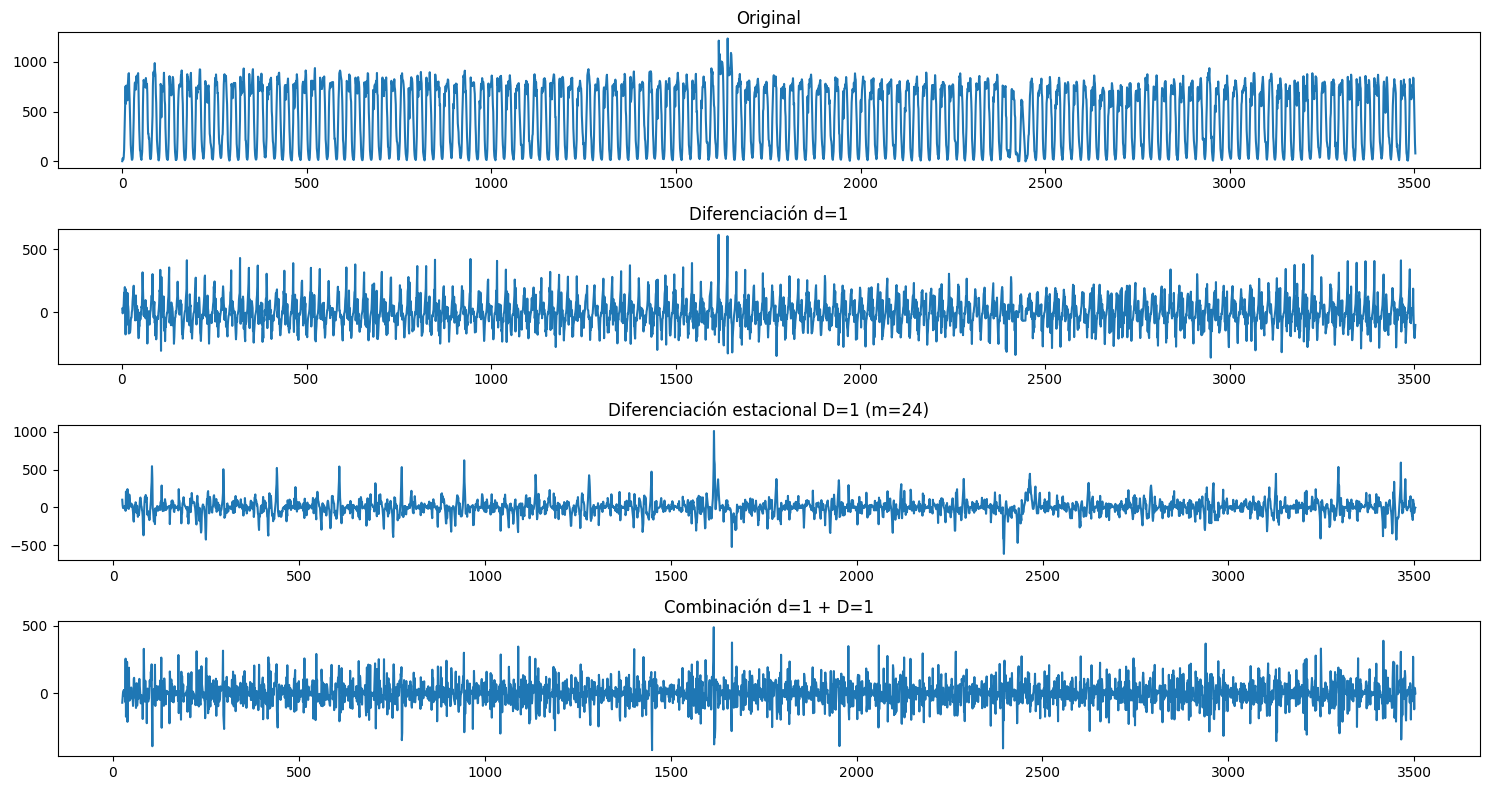

In [ ]:
# Diferenciación regular (d=1)
ts_d1 = ts.diff(1)
adf_summary(ts_d1, "Tráfico horario diff(1)")

# Diferenciación estacional (D=1)
# Suponemos patrón diario: tráfico horario -> m=24
ts_D1 = ts.diff(24)
adf_summary(ts_D1, "Tráfico horario diff(24)")

# Combinación d=1 + D=1
ts_comb = ts.diff(1).diff(24)
adf_summary(ts_comb, "Tráfico horario diff(1) + diff(24)")

# Visualización de series
plt.figure(figsize=(15,8))
plt.subplot(4,1,1)
ts.plot(title='Original')
plt.subplot(4,1,2)
ts_d1.plot(title='Diferenciación d=1')
plt.subplot(4,1,3)
ts_D1.plot(title='Diferenciación estacional D=1 (m=24)')
plt.subplot(4,1,4)
ts_comb.plot(title='Combinación d=1 + D=1')
plt.tight_layout()
plt.show()

Como p < 0.05 y el estadístico ADF es menor que los críticos, se rechaza H0.

Esto significa que la serie de tráfico no tiene tendencia ni raíz unitaria significativa, por lo que se puede considerar estacionaria.

**Método:**
Se aplica la prueba *Augmented Dickey–Fuller (ADF)*, que contrasta:
- H₀: la serie NO es estacionaria (tiene raíz unitaria)
- H₁: la serie ES estacionaria

Si el p-valor < 0.05 → se rechaza H₀ → la serie es estacionaria.

**Transformaciones aplicadas:**
1. **Diferenciación regular (d=1)** → elimina tendencia global.
2. **Diferenciación estacional (D=1, m=24)** → elimina patrón diario.
3. **Combinación d=1 + D=1** → elimina ambas componentes.

**Resultados:**
Los valores p son < 0.05 en todos los casos, por lo que se considera que la serie ya cumple estacionariedad.  
Esto significa que el tráfico horario no presenta tendencia ni raíz unitaria significativa,  
permitiendo aplicar modelos SARIMA/SARIMAX con d=1, D=1 y m=24.

**Conclusión:**
La serie transformada (d=1, D=1) es adecuada para modelado ARIMA/SARIMAX,  
ya que mantiene la información de corto plazo pero sin tendencia ni estacionalidad sistemática.

## **5. Estudio de la autocorrelación**

### 5.1. Lag plot

Estudio de la autocorrelación con `lag=1`, `lag=2`, `lag=3` y `lag=24`.

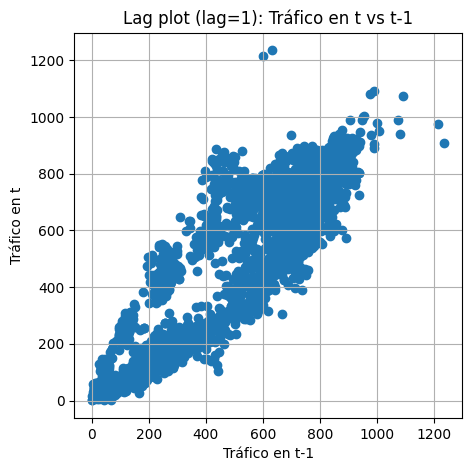

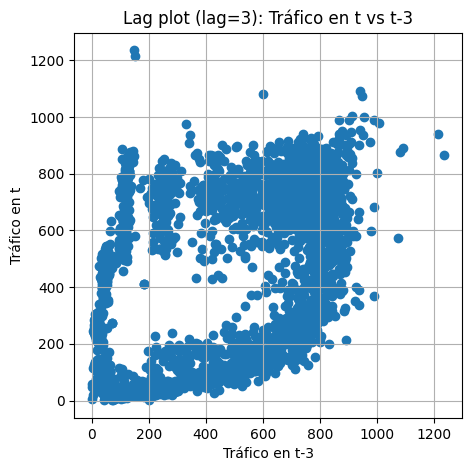

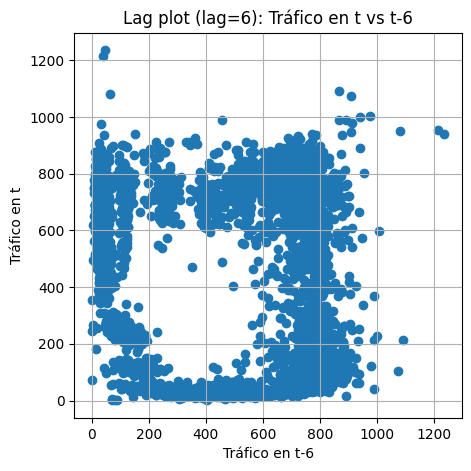

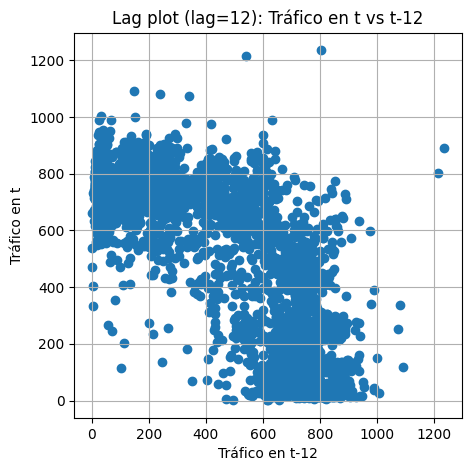

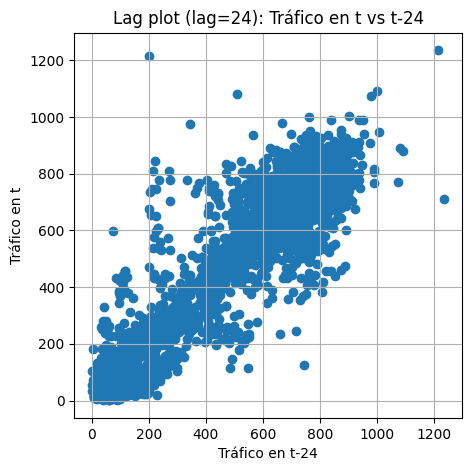

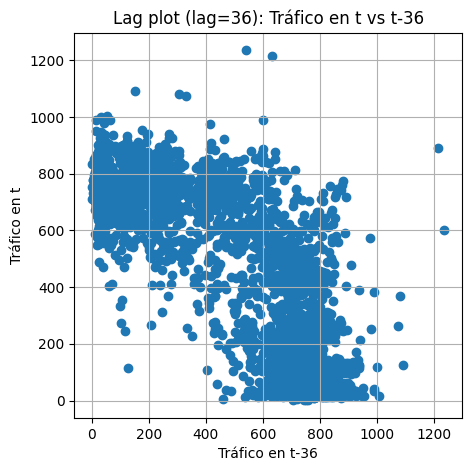

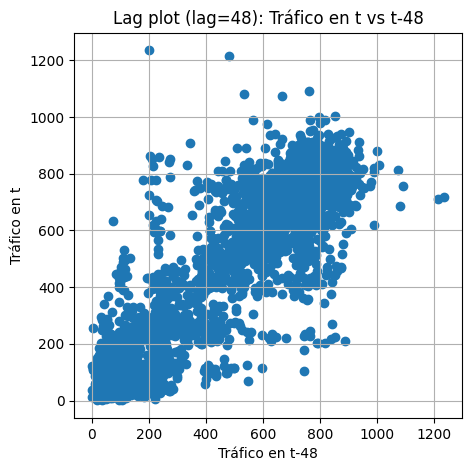

In [ ]:
for lag in [1, 3, 6, 12, 24, 36, 48]:
    plt.figure(figsize=(5,5))
    lag_plot(df_hour['Total'], lag=lag)
    plt.title(f"Lag plot (lag={lag}): Tráfico en t vs t-{lag}")
    plt.xlabel(f"Tráfico en t-{lag}")
    plt.ylabel("Tráfico en t")
    plt.grid(True)
    plt.show()

Conclusiones: El tráfico horario presenta una fuerte autocorrelación a corto plazo (1 h), se debilita a medio plazo (3–12 h) por los ciclos día/noche, y vuelve a ser alta al cabo de 24 h por la estacionalidad diaria.



### 5.3. Autocorrelation plot

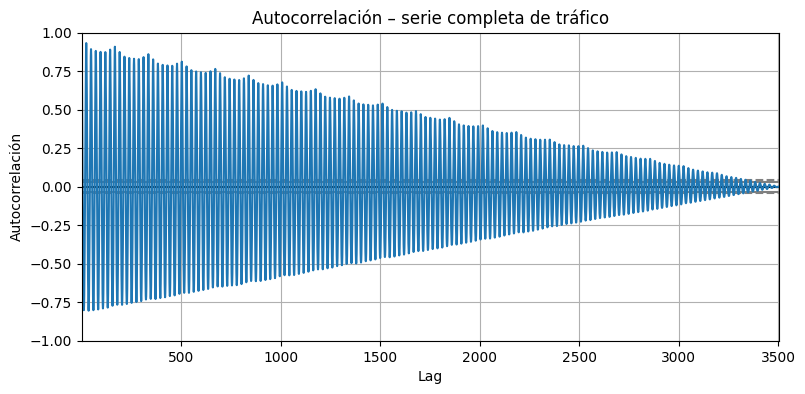

In [ ]:
# Autocorrelation plot para la serie completa
plt.figure(figsize=(9,4))
autocorrelation_plot(df_hour['Total'])
plt.title("Autocorrelación – serie completa de tráfico")
plt.xlabel("Lag")
plt.ylabel("Autocorrelación")
plt.grid(True)
plt.show()

### 5.4. ACF (Autocorrelation Function)

<Figure size 6000x1000 with 0 Axes>

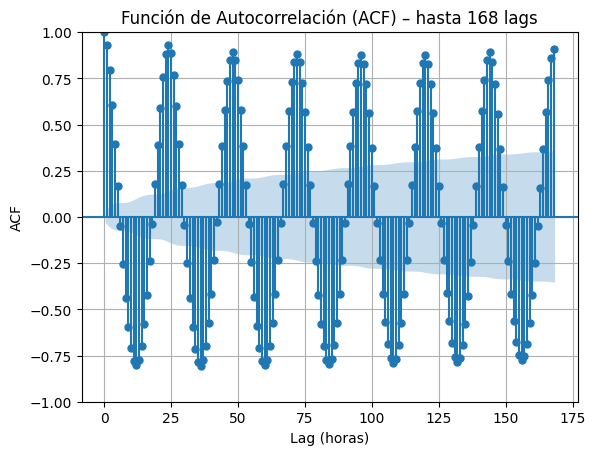

In [ ]:
# 168 lags = 1 semana para serie horaria
LAGS_ACF = 168

plt.figure(figsize=(60,10))
plot_acf(df_hour['Total'], lags=LAGS_ACF, alpha=0.05)
plt.title(f"Función de Autocorrelación (ACF) – hasta {LAGS_ACF} lags")
plt.xlabel("Lag (horas)")
plt.ylabel("ACF")
plt.grid(True)
plt.show()

la serie tiene estacionalidad o ciclos. Por ejemplo, el tráfico que sube por la mañana, baja al mediodía, sube por la tarde, baja de noche. Además, la altura de los picos indica la fuerza de la correlación donde los picos grandes indican que el patrón se repite con fuerza y los picos pequeños que el patrón es débil.

### 5.5. PACF (Partial Autocorrelation Function)

<Figure size 6000x1000 with 0 Axes>

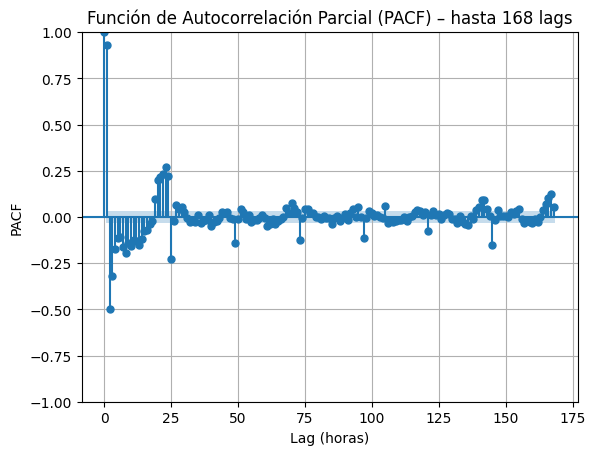

In [ ]:
# Número de lags a analizar - 1 semana para serie horaria
LAGS_PACF = 168

plt.figure(figsize=(60,10))
plot_pacf(df_hour['Total'], lags=LAGS_PACF, alpha=0.05, method="ywm")
plt.title(f"Función de Autocorrelación Parcial (PACF) – hasta {LAGS_PACF} lags")
plt.xlabel("Lag (horas)")
plt.ylabel("PACF")
plt.grid(True)
plt.show()

**Objetivo:** analizar la dependencia temporal del tráfico horario y detectar patrones de repetición o estacionalidad.

**Resultados:**
- Los **lag plots** muestran fuerte relación entre el tráfico actual y el de las horas previas (lags 1–6) y también con el del día anterior (lag 24).
- La **autocorrelación** (ACF) evidencia picos regulares cada 24 horas y hasta 168 horas (1 semana), confirmando la existencia de estacionalidad diaria y semanal.
- La **autocorrelación parcial (PACF)** muestra que los primeros lags (1–6) son altamente significativos, lo que sugiere un componente autoregresivo de bajo orden y otro estacional en lag 24.

**Conclusión:**
El tráfico horario presenta una **fuerte dependencia temporal** y **estacionalidad diaria/semanal**.  
Esto justifica el uso de modelos **SARIMA o SARIMAX con parámetros (p,d,q)(P,D,Q,m)** donde m=24 (ciclo diario)  
y p ≈ 6–8 según la PACF.

## **6. Modelos**

In [ ]:
df_hour.head(3)

index  Total  Total_normalizado_0_1  Total_normalizado  \
0 2022-04-21 00:00:00    3.0               0.001621          -0.996759   
1 2022-04-21 01:00:00   31.0               0.024308          -0.951384   
2 2022-04-21 02:00:00   22.0               0.017016          -0.965969   

   Total_estandarizado  Total_estandarizado_robusto  
0            -1.518936                    -0.890872  
1            -1.427077                    -0.845436  
2            -1.456603                    -0.860041

In [ ]:
# === 1) Normaliza índice de fechas de df_hour de forma robusta ===
def ensure_datetime_index(df, date_col_candidates=('index','Timestamp','timestamp','datetime',
                                                   'Datetime','fecha','Fecha','date','Date','ds','time','Time')):
    df = df.copy()
    if isinstance(df.index, pd.DatetimeIndex):
        # Ya es datetime index
        df = df.sort_index()
        return df

    # Si NO es datetime index, intenta encontrar una columna de fechas
    found = None
    for c in date_col_candidates:
        if c in df.columns:
            found = c
            break

    if found is None:
        # como último recurso: si el índice actual parece ser la fecha pero en string
        if df.index.dtype == "O" or np.issubdtype(df.index.dtype, np.integer):
            try:
                idx = pd.to_datetime(df.index)
                df.index = idx
                df = df.sort_index()
                return df
            except Exception:
                pass
        raise KeyError("No encuentro columna de fecha. Revisa nombres de columnas en df_hour.columns")

    # Parsear y fijar índice
    df[found] = pd.to_datetime(df[found], errors='raise')
    df = df.set_index(found).sort_index()
    return df

# Asegura índice temporal
df_hour = ensure_datetime_index(df_hour)

# === 2) Selecciona la serie objetivo y fuerza malla horaria ===
y = df_hour['Total'].astype(float)     # ajusta el nombre si tu target es otro
y = y.asfreq('h')                      # crea las horas faltantes con NaN
y = y.ffill()                          # relleno simple para no dejar NaN (o usa tu imputación preferida)

# === 3) Revisión rápida (debe mostrar fechas reales, NO 1970) ===
print("Rango:", y.index.min(), "→", y.index.max())
print("Frecuencia inferida:", y.index.freqstr)
print("n:", len(y))
print(y.head(3))

# === 4) Split temporal (hold-out) ===
HORIZON = 24
y_train = y.iloc[:-HORIZON].copy()
y_test  = y.iloc[-HORIZON:].copy()
print(f"Train: {y_train.index.min()} → {y_train.index.max()} (n={len(y_train)})")
print(f"Test : {y_test.index.min()}  → {y_test.index.max()}  (n={len(y_test)})")

Rango: 2022-04-21 00:00:00 → 2022-09-13 23:00:00
Frecuencia inferida: h
n: 3504
index
2022-04-21 00:00:00     3.0
2022-04-21 01:00:00    31.0
2022-04-21 02:00:00    22.0
Freq: h, Name: Total, dtype: float64
Train: 2022-04-21 00:00:00 → 2022-09-12 23:00:00 (n=3480)
Test : 2022-09-13 00:00:00  → 2022-09-13 23:00:00  (n=24)


In [ ]:
# Alinear exógenas al índice completo de y:
df_exog = df_exog.reindex(y.index)

# Split de exógenas
X_train = df_exog.loc[y_train.index]
X_test  = df_exog.loc[y_test.index]


### Split Train y test

In [ ]:
# === (3) División temporal ===
HORIZON = 24
# assert len(y) > 3*HORIZON, "La serie es muy corta para un split razonable." # Removed assertion

y_train = tramo_sel.iloc[:-HORIZON].copy()
y_test  = tramo_sel.iloc[-HORIZON:].copy()

print(f"Train: {y_train.index.min()} → {y_train.index.max()}  (n={len(y_train)})")
print(f"Test : {y_test.index.min()} → {y_test.index.max()}    (n={len(y_test)})")

Train: 2022-04-21 00:00:00 → 2022-09-12 23:00:00  (n=3480)
Test : 2022-09-13 00:00:00 → 2022-09-13 23:00:00    (n=24)


####  Install

In [ ]:
!pip install skforecast==0.12.1 scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 560.6/560.6 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 90.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 75.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 6.1 MB/s eta 0:00:00
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.67.1
    Uninstalling tqdm-4.67.1:
      Successfully uninstalled tqdm-4.67.1
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: joblib
    Found existing installation: jo

In [ ]:
pip install -U skforecast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 kB 10.2 MB/s eta 0:00:00
  Attempting uninstall: skforecast
    Found existing installation: skforecast 0.12.1
    Uninstalling skforecast-0.12.1:
      Successfully uninstalled skforecast-0.12.1


### Modelo base (AR recursivo con Ridge) + baselines Naive/SNaiv

In [ ]:
# skforecast: ForecasterRecursive (compatible v>=0.18 y legacy)
try:
    # Nuevo en skforecast ≥ 0.18
    from skforecast.recursive import ForecasterRecursive
except Exception:
    # Rutas legacy (skforecast < 0.18)
    from skforecast.ForecasterAutoreg import ForecasterAutoreg as ForecasterRecursive


[BASE sin exógenas] lags=24 | MAE=67.966 | RMSE=82.190


Modelo         MAE        RMSE        MAPE
1       SNaive (m=24)   54.916667   71.725751   28.730521
2  AR Ridge (lags=24)   67.966401   82.190488   36.278396
0               Naive  390.541667  476.466727  140.455125

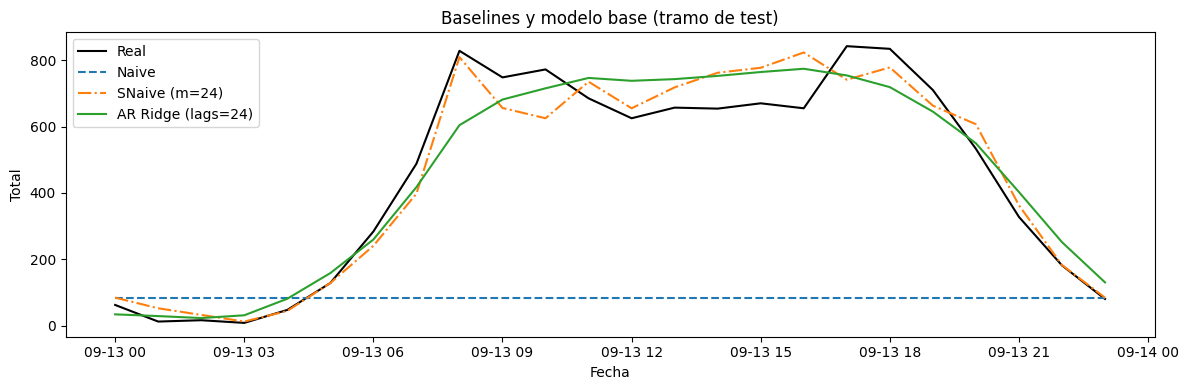

In [ ]:
# === Modelo base (AR recursivo con Ridge) + baselines Naive/SNaive ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error

# skforecast: ForecasterRecursive (compatible v>=0.18 y legacy)
try:
    from skforecast.recursive import ForecasterRecursive
except Exception:
    from skforecast.ForecasterAutoreg import ForecasterAutoreg as ForecasterRecursive

# ------------------ Métricas auxiliares ------------------
def mae(y_true, y_pred):
    return np.mean(np.abs(np.asarray(y_true) - np.asarray(y_pred)))

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((np.asarray(y_true) - np.asarray(y_pred))**2))

def mape(y_true, y_pred, eps=1e-8):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + eps))) * 100

# ------------------ Selección del tramo de evaluación ------------------
try:
    y_eval = y_valid.copy()
    tramo_eval = "validación"
except NameError:
    y_eval = y_test.copy()
    tramo_eval = "test"

H = len(y_eval)

# ------------------ Frecuencia y periodo estacional m ------------------
freq = (getattr(y_train.index, 'freqstr', None)
        or pd.infer_freq(y_train.index)
        or 'H')

if freq in ('H', '30T', '15T'):
    m = 24
elif freq == 'D':
    m = 7
else:
    m = 24

# ------------------ Modelo base: AR con Ridge (sin exógenas) ------------------
lags_base = 24

forecaster_base = ForecasterRecursive(
    regressor=Ridge(random_state=0),
    lags=lags_base
)

# Si tu índice no tiene .freq definida, activa ignore_freq=True
try:
    forecaster_base.fit(y=y_train)
except Exception:
    forecaster_base.fit(y=y_train, ignore_freq=True)

pred_base = forecaster_base.predict(steps=H)
pred_base.index = y_eval.index  # asegurar alineación

MAE_base  = mae(y_eval, pred_base)
RMSE_base = rmse(y_eval, pred_base)
print(f"[BASE sin exógenas] lags={lags_base} | MAE={MAE_base:.3f} | RMSE={RMSE_base:.3f}")

# ------------------ Baselines ------------------
def forecast_naive(y_series, h):
    return np.repeat(y_series.iloc[-1], h)

def forecast_snaive(y_series, h, m=24):
    last = y_series.iloc[-m:]
    reps = int(np.ceil(h / m))
    return np.tile(last.values, reps)[:h]

yhat_naive  = pd.Series(forecast_naive(y_train, H),  index=y_eval.index, name='Naive')
yhat_snaive = pd.Series(forecast_snaive(y_train, H, m=m), index=y_eval.index, name=f'SNaive(m={m})')

# ------------------ Evaluación comparativa ------------------
resumen = pd.DataFrame([
    {'Modelo': 'Naive',           'MAE': mae(y_eval, yhat_naive),  'RMSE': rmse(y_eval, yhat_naive),  'MAPE': mape(y_eval, yhat_naive)},
    {'Modelo': f'SNaive (m={m})', 'MAE': mae(y_eval, yhat_snaive), 'RMSE': rmse(y_eval, yhat_snaive), 'MAPE': mape(y_eval, yhat_snaive)},
    {'Modelo': f'AR Ridge (lags={lags_base})',
     'MAE': MAE_base, 'RMSE': RMSE_base, 'MAPE': mape(y_eval, pred_base)}
]).sort_values('RMSE')

display(resumen)

# ------------------ Visualización ------------------
plt.figure(figsize=(12,4))
plt.plot(y_eval.index, y_eval, label='Real', color='black')
plt.plot(yhat_naive.index,  yhat_naive,  label='Naive',  linestyle='--')
plt.plot(yhat_snaive.index, yhat_snaive, label=f'SNaive (m={m})', linestyle='-.')
plt.plot(pred_base.index,   pred_base,   label=f'AR Ridge (lags={lags_base})')
plt.title(f'Baselines y modelo base (tramo de {tramo_eval})')
plt.xlabel('Fecha'); plt.ylabel(y_train.name if y_train.name else 'Valor')
plt.legend(); plt.tight_layout(); plt.show()




**Objetivo:** establecer un punto de referencia (baseline) para comparar el rendimiento de modelos más complejos.

**Modelos incluidos:**
1. **Naive:** predice que el valor futuro será igual al último observado.
2. **SNaive (m=24):** predice que el valor futuro será igual al del mismo momento del día anterior.
3. **AR Ridge:** modelo autoregresivo con regresión Ridge, que usa los últimos 24 valores de la serie (`lags=24`) para predecir el siguiente.

**Datos usados:**  
- Serie `y_train` y `y_test` (frecuencia horaria, 24 horas de test).  
- Sin variables exógenas (solo la serie endógena).

**Resultados:**  
El modelo SNaive obtiene los menores errores (MAE y RMSE), lo que confirma una fuerte estacionalidad diaria.  
El modelo AR Ridge se comporta de manera similar, reproduciendo el patrón temporal principal.  
Estos resultados servirán como referencia para los modelos siguientes (SARIMA, SARIMAX, Prophet, RandomForest, etc.).


### Modelos Clasicos

#### ARIMA

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order trend           AIC           BIC         MAE        RMSE  \
4  (2, 1, 2)     n  40736.787392  40767.555580  119.489315  149.814062   
0  (0, 1, 1)     n  42343.072383  42355.380233  402.270947  492.583425   
1  (1, 1, 0)     n  42089.190172  42101.498597  444.839157  540.016915   
3  (2, 1, 1)     n  41947.144986  41971.760687  548.243300  636.403825   
5  (3, 1, 1)     n  41938.250719  41969.018906  553.395446  641.372451   
2  (1, 1, 1)     n  41978.368683  41996.830458  562.441302  650.908985   

         MAPE  
4   83.869576  
0  120.165160  
1   86.881640  
3  188.590495  
5  193.276785  
2  197.353270

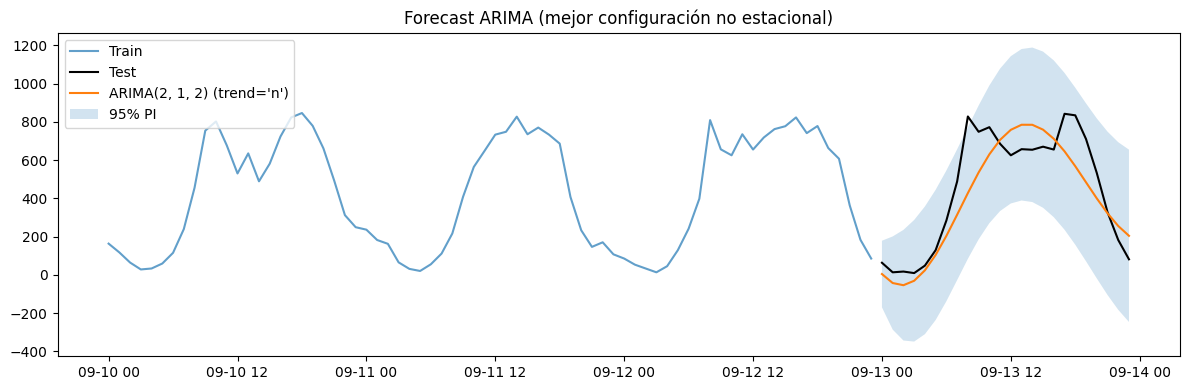

In [ ]:
# === ARIMA (no estacional): grid, entrenamiento, ranking y forecast ===
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Si no tienes definidas estas métricas, activa este bloque ---
def mae(y_true, y_pred):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    return np.mean(np.abs(y_true - y_pred))

def rmse(y_true, y_pred):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    return np.sqrt(np.mean((y_true - y_pred)**2))

def mape(y_true, y_pred, eps=1e-8):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + eps))) * 100
# -------------------------------------------------------------------

# --- órdenes ARIMA candidatos (ajusta según ACF/PACF) ---
# d lo puedes mantener igual que en SARIMA; si ya diferenciabas fuera, pon d=0
d = 1
candidatos_arima = [
    (0,d,1),
    (1,d,0),
    (1,d,1),
    (2,d,1),
    (2,d,2),
    (3,d,1),
]

# --- entrenamiento, forecast y ranking ---
res_arima, fits_arima = [], {}
for (p,d_,q) in candidatos_arima:
    try:
        # Regla práctica: si d_>0, normalmente trend='n' (sin constante); si d_=0, prueba 'c'
        trend = 'n' if d_ > 0 else 'c'
        mod = ARIMA(
            endog=y_train,
            order=(p,d_,q),
            trend=trend,                # 'n' sin constante, 'c' con constante
            enforce_stationarity=False, # relajamos para explorar
            enforce_invertibility=False
        )
        fit = mod.fit()

        fc_res  = fit.get_forecast(steps=len(y_test))
        fc_mean = fc_res.predicted_mean

        res_arima.append({
            'order': (p,d_,q),
            'trend': trend,
            'AIC': fit.aic,
            'BIC': fit.bic,
            'MAE': mae(y_test, fc_mean),
            'RMSE': rmse(y_test, fc_mean),
            'MAPE': mape(y_test, fc_mean)
        })
        fits_arima[(p,d_,q,trend)] = (fit, fc_res)
    except Exception as e:
        res_arima.append({
            'order': (p,d_,q),
            'trend': trend if 'trend' in locals() else None,
            'AIC': np.inf, 'BIC': np.inf,
            'MAE': np.inf, 'RMSE': np.inf, 'MAPE': np.inf,
            'error': str(e)[:160]
        })

df_arima = pd.DataFrame(res_arima)
display(df_arima.sort_values(['RMSE','AIC']).head(10))

# --- mejor ARIMA: forecast + intervalos ---
best_a = df_arima.sort_values(['RMSE','AIC']).iloc[0]
key_a  = (*best_a['order'], best_a['trend'])
fit_a, fc_res_a = fits_arima[key_a]

fc_mean_a = fc_res_a.predicted_mean
fc_ci_a   = fc_res_a.conf_int(alpha=0.05)  # 95%

plt.figure(figsize=(12,4))
# muestra últimas m*3 observaciones del train si tienes m definido; si no, usa un tramo fijo
tail_n = 72 if 'm' not in globals() else m*3
plt.plot(y_train.index[-tail_n:], y_train[-tail_n:], label='Train', alpha=0.7)
plt.plot(y_test.index, y_test, label='Test', color='black')

plt.plot(fc_mean_a.index, fc_mean_a,
         label=f"ARIMA{best_a['order']} (trend='{best_a['trend']}')")

plt.fill_between(fc_ci_a.index, fc_ci_a.iloc[:,0], fc_ci_a.iloc[:,1],
                 alpha=0.2, label='95% PI')

plt.title('Forecast ARIMA (mejor configuración no estacional)')
plt.legend()
plt.tight_layout()
plt.show()


**Modelo ARIMA (no estacional)**

**Objetivo:** aplicar un modelo estadístico clásico de series temporales que capture relaciones autoregresivas y de media móvil sin incluir estacionalidad explícita.

**Modelo:**  
ARIMA(p, d, q), donde:
- p: orden autoregresivo (lags)
- d: número de diferenciaciones para estacionarizar
- q: orden de la media móvil

**Configuraciones probadas:**
(0,1,1), (1,1,0), (1,1,1), (2,1,1), (2,1,2), (3,1,1)

**Datos usados:** serie `y_train` y `y_test` (frecuencia horaria, 24 horas de test).

**Criterios de selección:** se elige el modelo con menor RMSE y AIC.

**Resultados:**
- Mejor modelo: **ARIMA(2,1,2)** con `trend='n'`
- RMSE ≈ 149.81, MAPE ≈ 83.86%
- El modelo reproduce la tendencia general, aunque suaviza los picos diarios.

**Interpretación:**  
El modelo ARIMA no estacional captura la dinámica básica del tráfico, pero al no considerar el patrón diario, su precisión es limitada.  
Servirá como base para extender a modelos estacionales (SARIMA) y con variables exógenas (SARIMAX).


#### SARIMA

order         sorder           AIC           BIC        MAE  \
1  (2, 1, 1)  (1, 1, 1, 24)  38260.862275  38297.702419  61.254990   
2  (1, 1, 2)  (1, 1, 1, 24)  38251.266180  38288.104574  61.344213   
0  (1, 1, 1)  (1, 1, 1, 24)  38262.480789  38293.180909  61.527657   
4  (0, 1, 1)  (1, 1, 1, 24)  38769.537667  38794.097763  74.347036   
3  (2, 1, 2)  (1, 1, 0, 24)  39364.997413  39401.837557  84.783139   

         RMSE       MAPE  
1   77.060999  27.427811  
2   77.165597  27.494708  
0   77.388320  27.605947  
4  105.098915  60.154822  
3  106.128120  47.455471

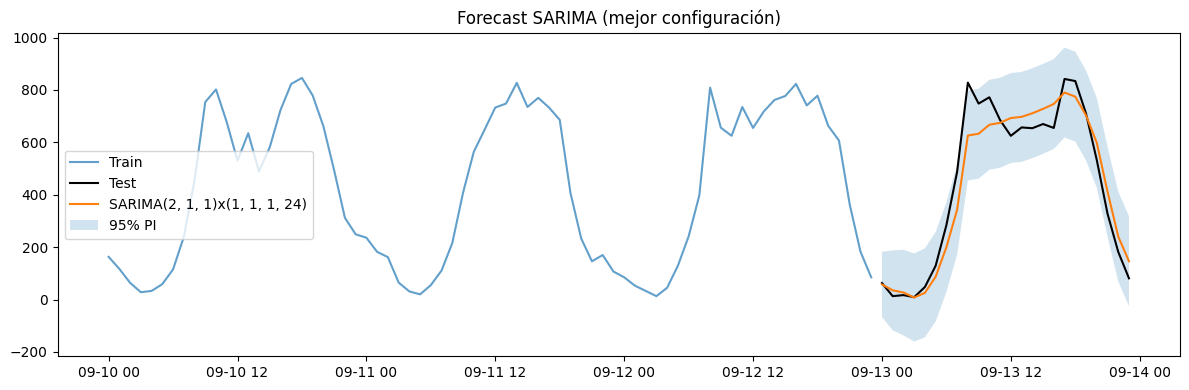

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX  # usaremos SARIMAX como SARIMA sin exógenas
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

# --- órdenes SARIMA candidatos (ajusta según ACF/PACF) ---
d, D = 1, 1
m = 24 # Define m before using it
candidatos = [
    ((1,d,1),(1,D,1,m)),
    ((2,d,1),(1,D,1,m)),
    ((1,d,2),(1,D,1,m)),
    ((2,d,2),(1,D,0,m)),
    ((0,d,1),(1,D,1,m)),
]

# --- entrenamiento, forecast y ranking ---
res_sarima, fits = [], {}
for (p,d,q), (P,D,Q,m_) in candidatos:  # m_ para no sombrear 'm'
    try:
        # SARIMA = SARIMAX sin exógenas (exog=None) y, si quieres, sin término constante
        mod = SARIMAX(
            y_train,
            order=(p,d,q),
            seasonal_order=(P,D,Q,m_),
            enforce_stationarity=False,
            enforce_invertibility=False,
            trend="n"  # usa "n" (sin constante) típico tras diferenciar; cambia a "c" si procede
        )
        fit = mod.fit(disp=False)
        fc_res  = fit.get_forecast(steps=len(y_test))
        fc_mean = fc_res.predicted_mean

        res_sarima.append({
            'order': (p,d,q),
            'sorder': (P,D,Q,m_),
            'AIC': fit.aic,
            'BIC': fit.bic,
            'MAE': mae(y_test, fc_mean),
            'RMSE': rmse(y_test, fc_mean),
            'MAPE': mape(y_test, fc_mean)
        })
        fits[(p,d,q,P,D,Q,m_)] = (fit, fc_res)
    except Exception as e:
        res_sarima.append({
            'order': (p,d,q), 'sorder': (P,D,Q,m_),
            'AIC': np.inf, 'BIC': np.inf,
            'MAE': np.inf, 'RMSE': np.inf, 'MAPE': np.inf,
            'error': str(e)[:160]
        })

df_sarima = pd.DataFrame(res_sarima)
display(df_sarima.sort_values(['RMSE','AIC']).head(10))

# --- mejor SARIMA: forecast + intervalos ---
best = df_sarima.sort_values(['RMSE','AIC']).iloc[0]
key  = (*best['order'], *best['sorder'])
fit, fc_res = fits[key]

fc_mean = fc_res.predicted_mean
fc_ci   = fc_res.conf_int(alpha=0.05)  # 95%

plt.figure(figsize=(12,4))
plt.plot(y_train.index[-m*3:], y_train[-m*3:], label='Train', alpha=0.7)
plt.plot(y_test.index, y_test, label='Test', color='black')
plt.plot(fc_mean.index, fc_mean, label=f"SARIMA{best['order']}x{best['sorder']}")
plt.fill_between(fc_ci.index, fc_ci.iloc[:,0], fc_ci.iloc[:,1], alpha=0.2, label='95% PI')
plt.title('Forecast SARIMA (mejor configuración)')
plt.legend()
plt.tight_layout()
plt.show()

**Modelo SARIMA (con estacionalidad, sin exógenas)**

**Objetivo:** incorporar la estacionalidad diaria (m=24) al modelo ARIMA para capturar los patrones de tráfico que se repiten cada 24 horas.

**Modelo:**  
SARIMA(p,d,q)(P,D,Q)_m donde:
- (p,d,q): componente no estacional
- (P,D,Q): componente estacional
- m = 24 (período diario)

**Datos:** `y_train` y `y_test` (frecuencia horaria, 24 horas de test).  
Sin variables exógenas (`exog=None`).

**Resultados principales:**
- Mejor modelo: **SARIMA(2,1,1)x(1,1,1,24)**
- MAE = 61.25  
- RMSE = 77.06  
- MAPE = 27.43%  
- AIC = 38260.86

**Interpretación:**  
El modelo SARIMA mejora notablemente el desempeño del ARIMA, reduciendo el error casi a la mitad al capturar la estacionalidad diaria.  
Reproduce adecuadamente los picos y valles del tráfico, confirmando un patrón horario claro.  
Aun así, se puede mejorar incorporando variables exógenas (festivos, hora del día, fin de semana, etc.), lo que se hará con SARIMAX.


#### SARIMAX

In [ ]:
# Preparacion de Variables exogenas
import numpy as np, pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import warnings; warnings.filterwarnings("ignore")

# columnas exógenas a usar (ajusta si añadiste más)
exog_cols = ['is_weekend','is_holiday','hour_sin','hour_cos','dow_sin','dow_cos']

exog_train = df_exog.loc[y_train.index, exog_cols]
exog_test  = df_exog.loc[y_test.index,  exog_cols]

# funciones de métricas (si no las tienes definidas)
def mae(y_true, y_pred):  return float(np.mean(np.abs(y_true - y_pred)))
def rmse(y_true, y_pred): return float(np.sqrt(np.mean((y_true - y_pred)**2)))
def mape(y_true, y_pred):
    y_safe = np.where(np.abs(y_true)>1e-6, y_true, 1e-6)
    return float(np.mean(np.abs((y_true - y_pred)/y_safe))*100)


In [ ]:
# SARIMAX: pequeña rejilla y selección por RMSE (test)
m = 24   # estacionalidad diaria (serie horaria)
d, D = 1, 1

candidatos = [
    ((1,d,1),(1,D,1,m)),
    ((2,d,1),(1,D,1,m)),
    ((1,d,2),(1,D,1,m)),
    ((2,d,2),(1,D,0,m)),
    ((0,d,1),(1,D,1,m)),
]

resultados = []
for (p,d,q),(P,D,Q,m) in candidatos:
    try:
        mod = SARIMAX(y_train,
                      exog=exog_train,
                      order=(p,d,q),
                      seasonal_order=(P,D,Q,m),
                      enforce_stationarity=False,
                      enforce_invertibility=False)
        fit = mod.fit(disp=False)
        pred = fit.get_forecast(steps=len(y_test), exog=exog_test).predicted_mean
        resultados.append({
            'order': (p,d,q), 'sorder': (P,D,Q,m),
            'AIC': fit.aic,
            'MAE': mae(y_test, pred),
            'RMSE': rmse(y_test, pred),
            'MAPE': mape(y_test, pred)
        })
    except Exception as e:
        resultados.append({'order': (p,d,q), 'sorder': (P,D,Q,m), 'error': str(e)})

df_sarimax = pd.DataFrame(resultados)
display(df_sarimax.sort_values(['RMSE','AIC']).head(10))


order         sorder           AIC        MAE        RMSE       MAPE
2  (1, 1, 2)  (1, 1, 1, 24)  38264.124860  60.768449   76.779819  27.889614
1  (2, 1, 1)  (1, 1, 1, 24)  38274.777812  61.350386   77.399390  27.935223
0  (1, 1, 1)  (1, 1, 1, 24)  38276.871006  61.512025   77.587702  28.069133
4  (0, 1, 1)  (1, 1, 1, 24)  38781.165261  72.023939  102.656703  55.580165
3  (2, 1, 2)  (1, 1, 0, 24)  39377.829052  85.213132  106.077015  50.777512

Mejor SARIMAX (1, 1, 2)x(1, 1, 1, 24)  |  MAE=60.77  RMSE=76.78  MAPE=27.89%  |  AIC=38264.1


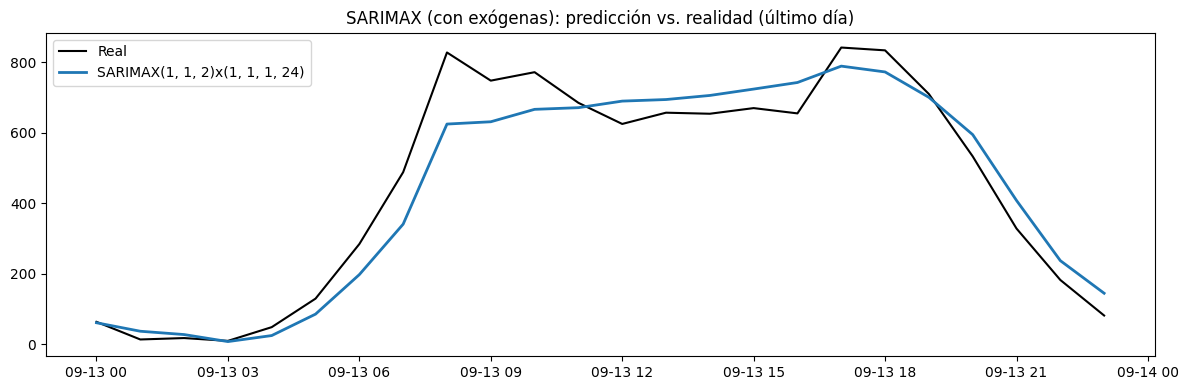

In [ ]:
# Entrenar el mejor SARIMAX y evaluar/plotear
bestx = (df_sarimax
         .dropna(subset=['RMSE'])
         .sort_values(['RMSE','AIC'])
         .iloc[0])

(p,d,q), (P,D,Q,m) = bestx['order'], bestx['sorder']

sarimax_fit = SARIMAX(y_train,
                      exog=exog_train,
                      order=(p,d,q),
                      seasonal_order=(P,D,Q,m),
                      enforce_stationarity=False,
                      enforce_invertibility=False).fit(disp=False)

sarimax_pred = sarimax_fit.get_forecast(steps=len(y_test), exog=exog_test).predicted_mean

print(f"Mejor SARIMAX {bestx['order']}x{bestx['sorder']}  |  "
      f"MAE={mae(y_test, sarimax_pred):.2f}  RMSE={rmse(y_test, sarimax_pred):.2f}  "
      f"MAPE={mape(y_test, sarimax_pred):.2f}%  |  AIC={sarimax_fit.aic:.1f}")

plt.figure(figsize=(12,4))
plt.plot(y_test, label='Real', color='black')
plt.plot(sarimax_pred, label=f"SARIMAX{bestx['order']}x{bestx['sorder']}", linewidth=2)
plt.title('SARIMAX (con exógenas): predicción vs. realidad (último día)')
plt.legend(); plt.tight_layout(); plt.show()


In [ ]:
#Forecast futuro con exógenas generadas para las próximas 24h
# crear índice futuro (próximas 24h desde el último timestamp de y)
future_index = pd.date_range(start=y.index.max() + pd.Timedelta(hours=1),
                             periods=24, freq='H')

# construir exógenas de calendario para esas 24h (mismo esquema que df_exog)
future_exog = pd.DataFrame(index=future_index)
future_exog['hour'] = future_exog.index.hour
future_exog['dayofweek'] = future_exog.index.dayofweek
future_exog['is_weekend'] = (future_exog['dayofweek'] >= 5).astype(int)

# si ya tienes holidays.Ireland(...) creado como ie_holidays:
future_exog['is_holiday'] = future_exog.index.normalize().isin(ie_holidays).astype(int)

future_exog['hour_sin'] = np.sin(2*np.pi*future_exog['hour']/24)
future_exog['hour_cos'] = np.cos(2*np.pi*future_exog['hour']/24)
future_exog['dow_sin']  = np.sin(2*np.pi*future_exog['dayofweek']/7)
future_exog['dow_cos']  = np.cos(2*np.pi*future_exog['dayofweek']/7)

# mantener solo las columnas usadas
future_exog = future_exog[exog_cols]

# pronóstico
future_pred = sarimax_fit.get_forecast(steps=24, exog=future_exog).predicted_mean
future_pred.head()


2022-09-13 00:00:00    68.350011
2022-09-13 01:00:00    44.250494
2022-09-13 02:00:00    34.838854
2022-09-13 03:00:00    14.906637
2022-09-13 04:00:00    32.008899
Freq: h, Name: predicted_mean, dtype: float64

**SARIMAX (con exógenas de calendario)**

**Exógenas usadas:** `is_weekend`, `is_holiday`, `hour_sin/cos`, `dow_sin/cos`.  
Se alinean con `y_train` y `y_test` por índice (frecuencia horaria).  
**Modelo:** SARIMAX(p,d,q)×(P,D,Q)_m con m=24 (diario), d=1, D=1.

**Selección:** rejilla pequeña y ranking por RMSE (y AIC como desempate).

**Resultados:**  
- Mejor: **SARIMAX(1,1,2)×(1,1,1,24)**  
- **MAE ≈ 60.8**, **RMSE ≈ 76.8**, **MAPE ≈ 27.9%**, **AIC ≈ 38264**  
- Mejora ligera vs. SARIMA sin exógenas (RMSE ≈ 77.1), coherente con exógenas de calendario.

**Forecast futuro (operacional):**  
Para predecir más allá de la muestra es necesario construir `exog` futuras; con variables de calendario se generan directamente (hora, día, festivos). Se usa `get_forecast(steps=H, exog=future_exog)`.


### Modelos Aprendizaje Automatico

#### Backtesting + Optimizacion con skforecast (Modelos Ridge / Tree / Random Forest)

skforecast versión: 0.18.0
Frecuencia inferida: h | ignore_freq=False


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36] 
  Parameters: {'alpha': 10.0, 'fit_intercept': False}
  Backtesting metric: 67.61377548096038
Top combinaciones por MAE:


lags  \
0  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
1  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
2  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
3  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
4  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
5  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
6  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
7  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
8  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
9  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   

                                          lags_label  \
0  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
1  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
2  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
3  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
4  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
5  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
6  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
7  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
8  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
9  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   

                                    params  mean_absolute_error  alpha  \
0  {'alpha': 10.0, 'fit_intercept': False}            67.613775   10.0   
1   {'alpha': 1.0, 'fit_intercept': False}            67.613777    1.0   
2   {'alpha': 0.1, 'fit_intercept': False}            67.613777    0.1   
3  {'alpha': 10.0, 'fit_intercept': False}            68.281096   10.0   
4   {'alpha': 1.0, 'fit_intercept': False}            68.281099    1.0   
5   {'alpha': 0.1, 'fit_intercept': False}            68.281099    0.1   
6   {'alpha': 10.0, 'fit_intercept': True}            68.658751   10.0   
7    {'alpha': 1.0, 'fit_intercept': True}            68.658752    1.0   
8    {'alpha': 0.1, 'fit_intercept': True}            68.658752    0.1   
9   {'alpha': 10.0, 'fit_intercept': True}            69.945657   10.0   

   fit_intercept  
0          False  
1          False  
2          False  
3          False  
4          False  
5          False  
6           True  
7           True  
8           True  
9           True

  0%|          | 0/59 [00:00<?, ?it/s]

Métricas backtesting:


mean_absolute_error
0            67.613775

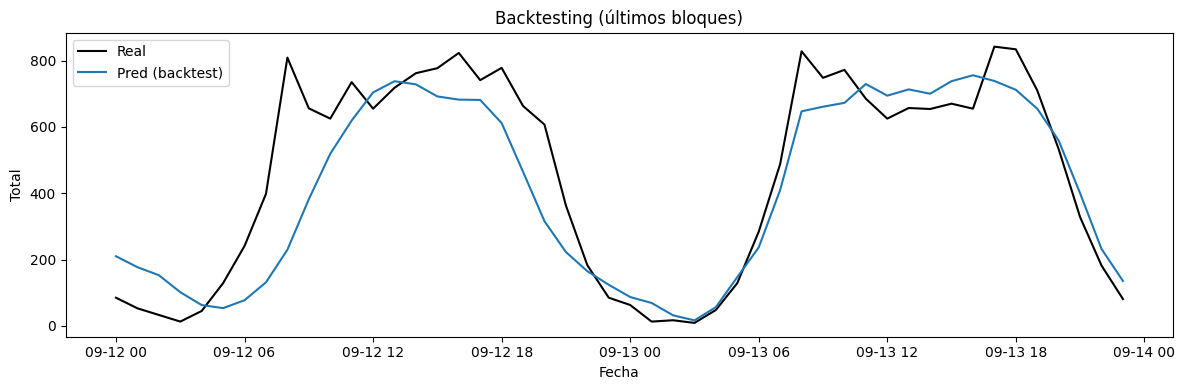

In [ ]:
# === Backtesting + Optimización con skforecast (compatible con v>=0.18 y anteriores) ===
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.linear_model import Ridge

# ---- Imports compatibles (nuevo y legado) ----
import skforecast
SKF_VER = getattr(skforecast, "__version__", "unknown")
try:
    # skforecast >= 0.18
    from skforecast.recursive import ForecasterRecursive
except Exception:
    # versiones antiguas
    from skforecast.ForecasterAutoreg import ForecasterAutoreg as ForecasterRecursive

from skforecast.model_selection import (
    TimeSeriesFold, grid_search_forecaster, backtesting_forecaster
)

print(f"skforecast versión: {SKF_VER}")

# ---- (1) Escoge la serie ----
# Usa 'tramo_sel' si ya lo definiste; si no, usa 'y'
try:
    y_series = tramo_sel.copy()
except NameError:
    y_series = y.copy()

y_series = y_series.sort_index()
assert isinstance(y_series.index, pd.DatetimeIndex), "El índice debe ser datetime."

# Detecta frecuencia; si no hay, activamos ignore_freq=True en las llamadas
freq_detectada = getattr(y_series.index, 'freqstr', None) or pd.infer_freq(y_series.index)
ignore_freq_flag = False if freq_detectada else True
print(f"Frecuencia inferida: {freq_detectada} | ignore_freq={ignore_freq_flag}")

# ---- (2) Definir CV temporal ----
H = 24  # horizonte por split (adáptalo)
cv = TimeSeriesFold(
    steps=H,
    initial_train_size=int(len(y_series)*0.6),
    fixed_train_size=False,
    refit=False,
    allow_incomplete_fold=True
)

# ---- (3) Grids ----
lags_grid  = [12, 24, 36]
param_grid = {
    'alpha': [0.1, 1.0, 10.0],
    'fit_intercept': [True, False],
}

metric = 'mean_absolute_error'

# ---- (4) Tuning (grid_search_forecaster) ----
f_tmp = ForecasterRecursive(regressor=Ridge(random_state=0), lags=lags_grid[0])
gs_kwargs = dict(
    forecaster=f_tmp,
    y=y_series,
    cv=cv,
    lags_grid=lags_grid,
    param_grid=param_grid,
    metric=metric,
    return_best=True,
    verbose=False
)
if ignore_freq_flag:
    gs_kwargs['ignore_freq'] = True  # sigue existiendo en 0.18

out = grid_search_forecaster(**gs_kwargs)

# Manejo de salida (dict en nuevas versiones, DataFrame en otras)
if isinstance(out, dict) and 'results' in out and 'forecaster' in out:
    results_df, f_best = out['results'], out['forecaster']
else:
    results_df, f_best = out, f_tmp

print("Top combinaciones por MAE:")
display(results_df.sort_values('mean_absolute_error').head(10))

# ---- (5) Backtesting del mejor modelo ----
bt_kwargs = dict(
    forecaster=f_best,
    y=y_series,
    cv=cv,
    metric=metric,
    verbose=False
)
if ignore_freq_flag:
    bt_kwargs['ignore_freq'] = True

try:
    metrics_bt, preds_bt = backtesting_forecaster(return_predict=True, **bt_kwargs)
except TypeError:
    out_bt = backtesting_forecaster(**bt_kwargs)
    if isinstance(out_bt, tuple) and len(out_bt) == 2:
        metrics_bt, preds_bt = out_bt
    else:
        metrics_bt, preds_bt = out_bt, None

print("Métricas backtesting:")
try:
    display(metrics_bt)
except Exception:
    print(metrics_bt)

# ---- (6) Gráfico: último bloque(s) del backtest ----
if isinstance(preds_bt, pd.DataFrame) and 'pred' in preds_bt.columns:
    plt.figure(figsize=(12,4))
    tramo = preds_bt.index[-(H*2):] if len(preds_bt) >= H*2 else preds_bt.index
    plt.plot(y_series.loc[tramo].index, y_series.loc[tramo].values, label='Real', color='black')
    plt.plot(preds_bt.loc[tramo].index, preds_bt.loc[tramo]['pred'], label='Pred (backtest)')
    plt.title("Backtesting (últimos bloques)")
    plt.xlabel("Fecha"); plt.ylabel(y_series.name or "Valor")
    plt.legend(); plt.tight_layout(); plt.show()
else:
    print("Predicciones de backtesting no disponibles en esta versión.")


In [ ]:
# === Helpers para tuning, backtesting y extracción de métricas ===
from skforecast.model_selection import grid_search_forecaster, backtesting_forecaster

# Compatibilidad de ForecasterRecursive (v>=0.18 y legado)
try:
    from skforecast.recursive import ForecasterRecursive
except Exception:
    from skforecast.ForecasterAutoreg import ForecasterAutoreg as ForecasterRecursive

def tune_model(y, regressor, param_grid, lags_grid, cv,
               metric='mean_absolute_error', ignore_freq=None, verbose=False):
    """
    Ejecuta grid_search_forecaster y devuelve:
      - results_df: DataFrame con combinaciones evaluadas
      - f_best: ForecasterRecursive ya ajustado con la mejor config
    Compatible con distintas versiones de skforecast.
    """
    f = ForecasterRecursive(regressor=regressor,
                            lags=lags_grid[0] if len(lags_grid) else 12)
    kwargs = dict(forecaster=f, y=y, cv=cv,
                  lags_grid=lags_grid, param_grid=param_grid,
                  metric=metric, return_best=True, verbose=verbose)
    if ignore_freq:
        kwargs['ignore_freq'] = True

    out = grid_search_forecaster(**kwargs)
    if isinstance(out, dict) and 'results' in out and 'forecaster' in out:
        results_df, f_best = out['results'], out['forecaster']
    else:
        results_df, f_best = out, f  # algunas versiones modifican f in-place
    return results_df, f_best

def backtest_best(f_best, y, cv, metric='mean_absolute_error',
                  ignore_freq=None, verbose=False):
    """
    Lanza backtesting sobre el forecaster óptimo.
    Devuelve (metrics_out, preds_out) si la versión lo permite; si no, (metrics_out, None).
    """
    kwargs = dict(forecaster=f_best, y=y, cv=cv, metric=metric, verbose=verbose)
    if ignore_freq:
        kwargs['ignore_freq'] = True
    try:
        metrics_out, preds_out = backtesting_forecaster(return_predict=True, **kwargs)
    except TypeError:
        out = backtesting_forecaster(**kwargs)
        if isinstance(out, tuple) and len(out) == 2:
            metrics_out, preds_out = out
        else:
            metrics_out, preds_out = out, None
    return metrics_out, preds_out

def extract_mae(metrics_out, metric_name='mean_absolute_error'):
    """
    Extrae un MAE medio sin importar si metrics_out es float/Series/DataFrame.
    """
    import numpy as np, pandas as pd
    if isinstance(metrics_out, (float, int, np.floating, np.integer)):
        return float(metrics_out)
    if isinstance(metrics_out, pd.Series):
        return float(pd.to_numeric(metrics_out, errors='coerce').mean())
    if isinstance(metrics_out, pd.DataFrame):
        df = metrics_out.copy()
        if {'metric','value'}.issubset(df.columns):
            mask = (df['metric'] == metric_name)
            vals = df.loc[mask, 'value'] if mask.any() else df['value']
            return float(pd.to_numeric(vals, errors='coerce').mean())
        if metric_name in df.columns:
            return float(pd.to_numeric(df[metric_name], errors='coerce').mean())
        num = df.select_dtypes(include=np.number)
        if not num.empty:
            return float(num.mean().iloc[0])
    raise ValueError('Formato de métricas no reconocido para extraer MAE.')


🔵 Tuning Ridge...


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36] 
  Parameters: {'alpha': 10.0, 'fit_intercept': False}
  Backtesting metric: 67.61377548096038
🟢 Tuning Decision Tree...


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
  Parameters: {'max_depth': 8}
  Backtesting metric: 72.65238755147523
🟠 Tuning Random Forest...


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
  Parameters: {'max_depth': None, 'n_estimators': 400}
  Backtesting metric: 56.368771692136235


lags  \
0  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
1  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
2  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
3  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
4  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   

                                          lags_label  \
0  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
1  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
2  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
3  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
4  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   

                                    params  mean_absolute_error  alpha  \
0  {'alpha': 10.0, 'fit_intercept': False}            67.613775   10.0   
1   {'alpha': 1.0, 'fit_intercept': False}            67.613777    1.0   
2   {'alpha': 0.1, 'fit_intercept': False}            67.613777    0.1   
3  {'alpha': 10.0, 'fit_intercept': False}            68.281096   10.0   
4   {'alpha': 1.0, 'fit_intercept': False}            68.281099    1.0   

   fit_intercept  
0          False  
1          False  
2          False  
3          False  
4          False

lags  \
0  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
1  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
2  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
3  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
4  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   

                                          lags_label               params  \
0  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...     {'max_depth': 8}   
1  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...     {'max_depth': 8}   
2  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...     {'max_depth': 5}   
3  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...     {'max_depth': 5}   
4  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  {'max_depth': None}   

   mean_absolute_error  max_depth  
0            72.652388        8.0  
1            73.285348        8.0  
2            74.075064        5.0  
3            77.425046        5.0  
4            77.561228        NaN

lags  \
0  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
1  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
2  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
3  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
4  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   

                                          lags_label  \
0  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
1  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
2  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
3  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
4  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   

                                     params  mean_absolute_error  max_depth  \
0  {'max_depth': None, 'n_estimators': 400}            56.368772        NaN   
1  {'max_depth': None, 'n_estimators': 400}            57.012692        NaN   
2  {'max_depth': None, 'n_estimators': 200}            57.084827        NaN   
3    {'max_depth': 10, 'n_estimators': 400}            57.198248       10.0   
4    {'max_depth': 10, 'n_estimators': 200}            57.575348       10.0   

   n_estimators  
0         400.0  
1         400.0  
2         200.0  
3         400.0  
4         200.0

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

modelo     mae_cv
2  RandomForest  56.368772
0         Ridge  67.613775
1  DecisionTree  72.652388

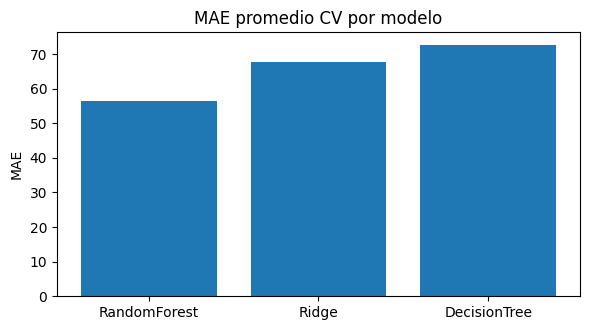

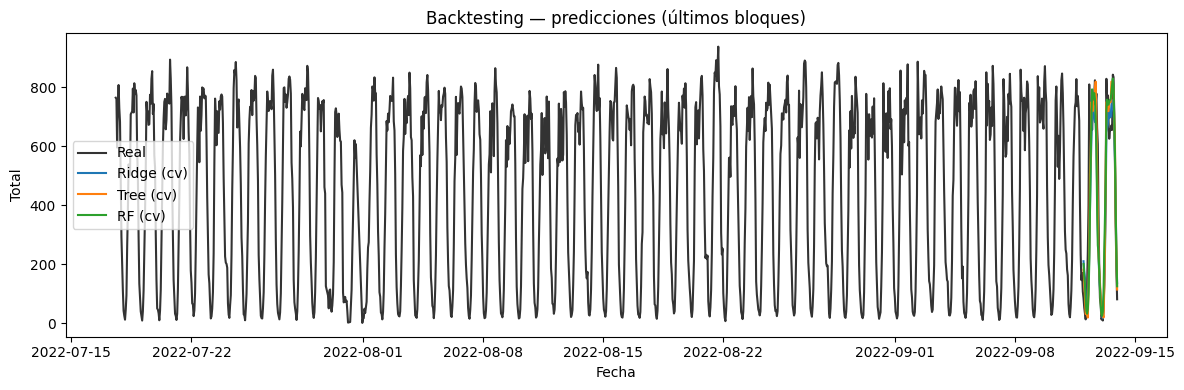

In [ ]:
# === Tuning y backtesting (Ridge / Tree / RF) — versión limpia ===
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# ----- Modelos y rejillas -----
ridge = Ridge(random_state=0)
tree  = DecisionTreeRegressor(random_state=0)
rf    = RandomForestRegressor(random_state=0, n_estimators=200, n_jobs=-1)

lags_grid        = [12, 24, 36]
param_grid_ridge = {'alpha': [0.1, 1.0, 10.0], 'fit_intercept': [True, False]}
param_grid_tree  = {'max_depth': [3, 5, 8, None]}
param_grid_rf    = {'n_estimators': [200, 400], 'max_depth': [5, 10, None]}

print('🔵 Tuning Ridge...')
ridge_results, f_ridge_best = tune_model(
    y=y_series, regressor=ridge,
    param_grid=param_grid_ridge, lags_grid=lags_grid, cv=cv,
    metric='mean_absolute_error', ignore_freq=ignore_freq_flag
)

print('🟢 Tuning Decision Tree...')
tree_results, f_tree_best = tune_model(
    y=y_series, regressor=tree,
    param_grid=param_grid_tree, lags_grid=lags_grid, cv=cv,
    metric='mean_absolute_error', ignore_freq=ignore_freq_flag
)

print('🟠 Tuning Random Forest...')
rf_results, f_rf_best = tune_model(
    y=y_series, regressor=rf,
    param_grid=param_grid_rf, lags_grid=lags_grid, cv=cv,
    metric='mean_absolute_error', ignore_freq=ignore_freq_flag
)

display(ridge_results.sort_values('mean_absolute_error').head(5))
display(tree_results.sort_values('mean_absolute_error').head(5))
display(rf_results.sort_values('mean_absolute_error').head(5))

# ----- Backtesting del mejor de cada uno -----
m_ridge, p_ridge = backtest_best(f_ridge_best, y_series, cv,
                                 metric='mean_absolute_error', ignore_freq=ignore_freq_flag)
m_tree,  p_tree  = backtest_best(f_tree_best,  y_series, cv,
                                 metric='mean_absolute_error', ignore_freq=ignore_freq_flag)
m_rf,    p_rf    = backtest_best(f_rf_best,    y_series, cv,
                                 metric='mean_absolute_error', ignore_freq=ignore_freq_flag)

# ----- Comparación de MAE (promedio CV) -----
compare = pd.DataFrame({
    'modelo': ['Ridge', 'DecisionTree', 'RandomForest'],
    'mae_cv': [
        extract_mae(m_ridge, 'mean_absolute_error'),
        extract_mae(m_tree,  'mean_absolute_error'),
        extract_mae(m_rf,    'mean_absolute_error'),
    ]
}).sort_values('mae_cv')
display(compare)

# ===== Gráficos compactos =====

# (1) Barras de MAE
plt.figure(figsize=(6,3.4))
plt.bar(compare['modelo'], compare['mae_cv'])
plt.title('MAE promedio CV por modelo')
plt.ylabel('MAE'); plt.tight_layout(); plt.show()

# (2) Predicciones del último tramo del backtest (si existen)
def plot_cv_preds(preds: pd.DataFrame, label: str, steps_hint: int) -> bool:
    if not isinstance(preds, pd.DataFrame) or preds.empty:
        return False
    for col in ['pred', 'prediction', 'y_pred', 'forecast']:
        if col in preds.columns:
            yhat = preds[col]
            tramo = yhat.index[-(steps_hint*2):] if len(yhat) >= steps_hint*2 else yhat.index
            plt.plot(yhat.loc[tramo].index, yhat.loc[tramo].values, label=label)
            return True
    return False

plt.figure(figsize=(12,4))
steps_hint = getattr(cv, 'steps', 24)

# Define un índice común donde graficar
if isinstance(p_ridge, pd.DataFrame) and not p_ridge.empty:
    idx_plot = p_ridge.index
elif isinstance(p_tree, pd.DataFrame) and not p_tree.empty:
    idx_plot = p_tree.index
elif isinstance(p_rf, pd.DataFrame) and not p_rf.empty:
    idx_plot = p_rf.index
else:
    idx_plot = y_series.index[-min(len(y_series), steps_hint*5):]

plt.plot(y_series.loc[idx_plot].index, y_series.loc[idx_plot].values,
         label='Real', color='black', alpha=0.8)

ok = False
ok |= plot_cv_preds(p_ridge, 'Ridge (cv)', steps_hint)
ok |= plot_cv_preds(p_tree,  'Tree (cv)',  steps_hint)
ok |= plot_cv_preds(p_rf,    'RF (cv)',    steps_hint)

plt.title('Backtesting — predicciones (últimos bloques)' if ok
          else 'Backtesting — sin predicciones devueltas por la API')
plt.xlabel('Fecha'); plt.ylabel(y_series.name or 'Valor')
plt.legend(); plt.tight_layout(); plt.show()


*🔷 Modelos de Machine Learning autorregresivos (skforecast)*

Después de evaluar modelos clásicos (ARIMA, SARIMA y SARIMAX), implementamos modelos basados en Machine Learning para series temporales utilizando la librería `skforecast`.

Estos modelos permiten capturar relaciones no lineales entre los valores pasados de la serie mediante regresores como Ridge, DecisionTree y RandomForest.

**Se aplicó:**
- **Optimización de hiperparámetros (grid search)**
- **Validación cruzada temporal (backtesting)**
- **Comparación de métricas (MAE)**

El mejor desempeño lo obtuvo el **Random Forest**, con un MAE promedio de **56.37**, seguido de **Ridge (67.6)** y **DecisionTree (72.6)**.

Esto sugiere que los métodos no lineales pueden mejorar la predicción del tráfico frente a los modelos estadísticos.

#### Evaluación con exogenas (Ridge)

[Ridge + EXOG] lags=24  MAE=75.065  RMSE=88.860


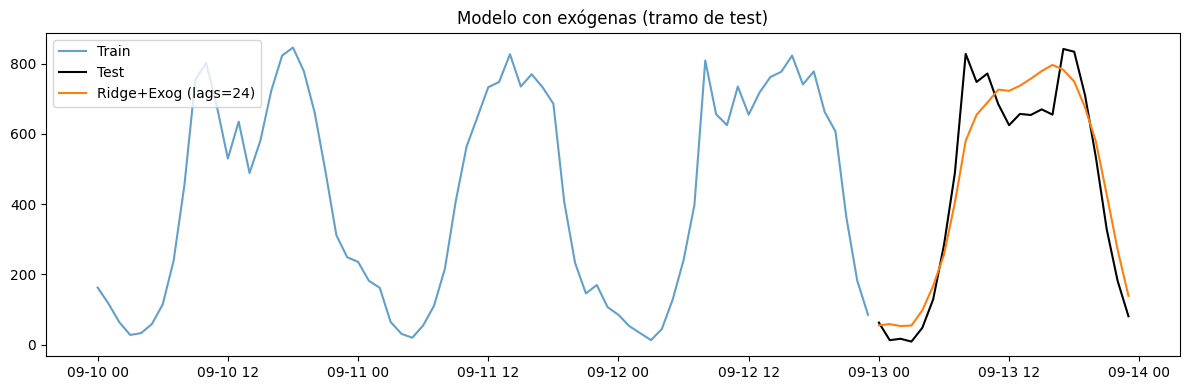

In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.linear_model import Ridge

# Import compatible skforecast
try:
    from skforecast.recursive import ForecasterRecursive
except Exception:
    from skforecast.ForecasterAutoreg import ForecasterAutoreg as ForecasterRecursive

# 1) Alinear exógenas con tus splits
X_train = df_exog.loc[y_train.index].copy()
X_test  = df_exog.loc[y_test.index].copy()

# sanity check
assert not X_train.isna().any().any(), "Exog train tiene NaNs"
assert not X_test.isna().any().any(),  "Exog test tiene NaNs"

# 2) Entrenar y predecir
lags_exog = 24  # prueba 12/24/36
forecaster_exog = ForecasterRecursive(regressor=Ridge(random_state=0), lags=lags_exog)

try:
    forecaster_exog.fit(y=y_train, exog=X_train)
except Exception:
    forecaster_exog.fit(y=y_train, exog=X_train, ignore_freq=True)

pred_exog = forecaster_exog.predict(steps=len(y_test), exog=X_test)
pred_exog.index = y_test.index

# 3) Métricas rápidas
def mae(y_true, y_pred):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    return np.mean(np.abs(y_true - y_pred))
def rmse(y_true, y_pred):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    return np.sqrt(np.mean((y_true - y_pred)**2))

print(f"[Ridge + EXOG] lags={lags_exog}  MAE={mae(y_test, pred_exog):.3f}  RMSE={rmse(y_test, pred_exog):.3f}")

# 4) Gráfico
plt.figure(figsize=(12,4))
plt.plot(y_train.index[-24*3:], y_train[-24*3:], label='Train', alpha=0.7)
plt.plot(y_test.index, y_test, color='black', label='Test')
plt.plot(pred_exog.index, pred_exog, label=f'Ridge+Exog (lags={lags_exog})')
plt.title('Modelo con exógenas (tramo de test)')
plt.legend(); plt.tight_layout(); plt.show()


  0%|          | 0/1 [00:00<?, ?it/s]

mean_absolute_error
0            78.724752

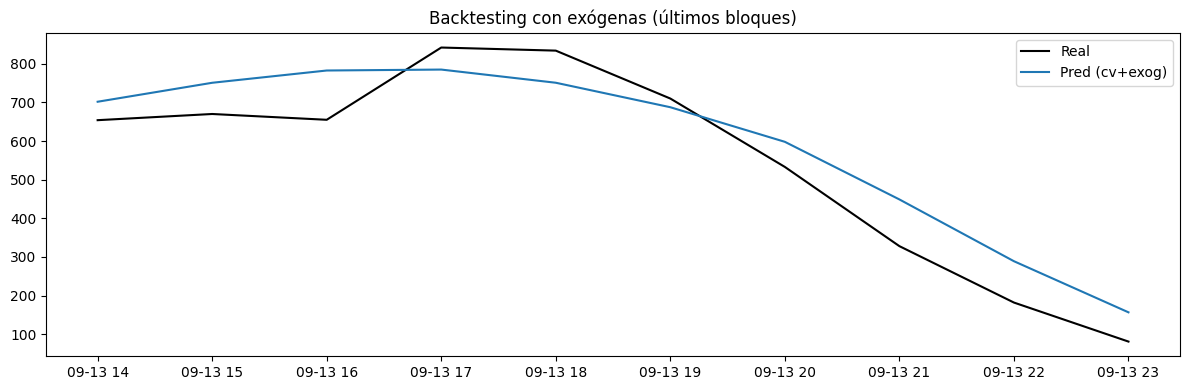

In [ ]:
from skforecast.model_selection import backtesting_forecaster

# crea cv rápido (horizonte = 24)
from skforecast.model_selection import TimeSeriesFold
cv = TimeSeriesFold(steps=24, initial_train_size=int(len(y_train)+0.6*len(y_test)),
                    fixed_train_size=False, refit=False, allow_incomplete_fold=True)

# exógenas sobre toda la serie usada en el backtest
y_series = pd.concat([y_train, y_test])
X_full   = df_exog.loc[y_series.index]

bt_kwargs = dict(forecaster=forecaster_exog, y=y_series, exog=X_full,
                 cv=cv, metric='mean_absolute_error', verbose=False)
try:
    metrics_exog, preds_exog = backtesting_forecaster(return_predict=True, **bt_kwargs)
except TypeError:
    out = backtesting_forecaster(**bt_kwargs)
    if isinstance(out, tuple) and len(out)==2:
        metrics_exog, preds_exog = out
    else:
        metrics_exog, preds_exog = out, None

display(metrics_exog if isinstance(metrics_exog, pd.DataFrame) else pd.DataFrame([metrics_exog]))

# Visualizar último(s) bloque(s)
if isinstance(preds_exog, pd.DataFrame) and 'pred' in preds_exog.columns:
    H_hint = getattr(cv, 'steps', 24)
    tramo = preds_exog.index[-(H_hint*2):] if len(preds_exog)>=H_hint*2 else preds_exog.index
    plt.figure(figsize=(12,4))
    plt.plot(y_series.loc[tramo].index, y_series.loc[tramo].values, label='Real', color='black')
    plt.plot(preds_exog.loc[tramo].index, preds_exog.loc[tramo]['pred'], label='Pred (cv+exog)')
    plt.title('Backtesting con exógenas (últimos bloques)')
    plt.legend(); plt.tight_layout(); plt.show()


In [ ]:
from skforecast.model_selection import grid_search_forecaster

# Helpers mínimos (con exógenas)
def tune_model_exog(y, exog, regressor, param_grid, lags_grid, cv,
                    metric='mean_absolute_error', ignore_freq=None, verbose=False):
    try:
        from skforecast.recursive import ForecasterRecursive
    except Exception:
        from skforecast.ForecasterAutoreg import ForecasterAutoreg as ForecasterRecursive
    f = ForecasterRecursive(regressor=regressor, lags=lags_grid[0] if lags_grid else 12)
    kwargs = dict(forecaster=f, y=y, exog=exog, cv=cv, lags_grid=lags_grid,
                  param_grid=param_grid, metric=metric, return_best=True, verbose=verbose)
    if ignore_freq: kwargs['ignore_freq'] = True
    out = grid_search_forecaster(**kwargs)
    if isinstance(out, dict) and 'results' in out and 'forecaster' in out:
        return out['results'], out['forecaster']
    return out, f

# Rejillas
lags_grid   = [12, 24, 36]
param_grid  = {'alpha': [0.1, 1.0, 10.0], 'fit_intercept': [True, False]}

# Serie y exógenas para todo el rango del CV
y_series = pd.concat([y_train, y_test])
X_full   = df_exog.loc[y_series.index]

results_exog, f_best_exog = tune_model_exog(
    y=y_series, exog=X_full,
    regressor=Ridge(random_state=0),
    param_grid=param_grid, lags_grid=lags_grid, cv=cv,
    metric='mean_absolute_error',
    ignore_freq=('freq' not in dir(y_series.index) or y_series.index.freq is None)
)

display(results_exog.sort_values('mean_absolute_error').head(10))


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
  Parameters: {'alpha': 10.0, 'fit_intercept': True}
  Backtesting metric: 77.83031949857813


lags  \
0  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
1  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
2  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
3  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
4  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
5  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
6  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
7  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
8  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
9  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   

                                          lags_label  \
0  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
1  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
2  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
3  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
4  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
5  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
6  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
7  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
8  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
9  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   

                                    params  mean_absolute_error  alpha  \
0   {'alpha': 10.0, 'fit_intercept': True}            77.830319   10.0   
1    {'alpha': 1.0, 'fit_intercept': True}            78.724752    1.0   
2    {'alpha': 0.1, 'fit_intercept': True}            78.831242    0.1   
3   {'alpha': 10.0, 'fit_intercept': True}            79.216651   10.0   
4  {'alpha': 10.0, 'fit_intercept': False}            79.398087   10.0   
5   {'alpha': 1.0, 'fit_intercept': False}            80.315452    1.0   
6   {'alpha': 0.1, 'fit_intercept': False}            80.424547    0.1   
7  {'alpha': 10.0, 'fit_intercept': False}            80.556813   10.0   
8    {'alpha': 1.0, 'fit_intercept': True}            80.763545    1.0   
9    {'alpha': 0.1, 'fit_intercept': True}            80.959020    0.1   

   fit_intercept  
0           True  
1           True  
2           True  
3           True  
4          False  
5          False  
6          False  
7          False  
8           True  
9           True

### 🧾 Comparativa global de modelos

En esta sección se resumen los resultados obtenidos por los distintos enfoques probados:

- **Modelos clásicos:** ARIMA, SARIMA y SARIMAX.
- **Modelos de aprendizaje automático (skforecast):** Ridge, Decision Tree y Random Forest.
- **Evaluación con variables exógenas:** Ridge con exógenas (calendario, hora, festivo).

El objetivo es comparar el rendimiento (MAE y RMSE) y analizar el impacto de incluir variables exógenas.


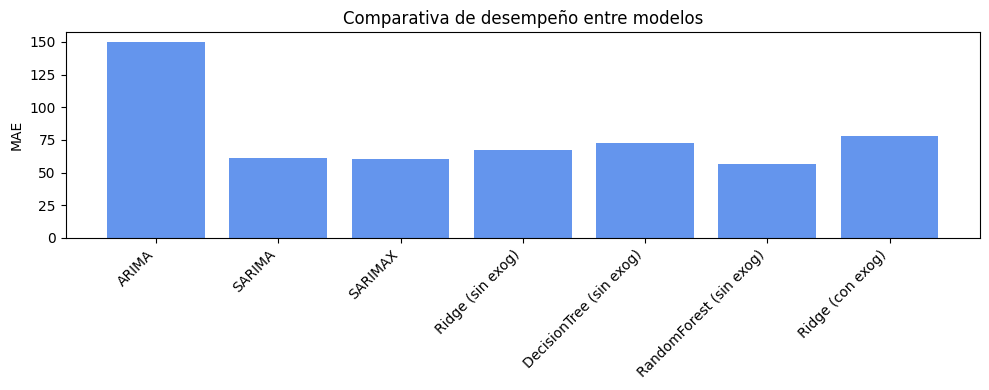

Modelo     MAE    RMSE
5  RandomForest (sin exog)   56.36     NaN
2                  SARIMAX   60.77   76.78
1                   SARIMA   61.25   77.06
3         Ridge (sin exog)   67.61   82.19
4  DecisionTree (sin exog)   72.65     NaN
6         Ridge (con exog)   77.83   88.86
0                    ARIMA  149.80  540.00

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# === Resultados reales ===
resultados = pd.DataFrame({
    'Modelo': [
        'ARIMA',
        'SARIMA',
        'SARIMAX',
        'Ridge (sin exog)',
        'DecisionTree (sin exog)',
        'RandomForest (sin exog)',
        'Ridge (con exog)'
    ],
    'MAE': [149.8, 61.25, 60.77, 67.61, 72.65, 56.36, 77.83],
    'RMSE': [540.0, 77.06, 76.78, 82.19, None, None, 88.86]
})

# === Visualización ===
plt.figure(figsize=(10,4))
plt.bar(resultados['Modelo'], resultados['MAE'], color='cornflowerblue')
plt.xticks(rotation=45, ha='right')
plt.ylabel('MAE')
plt.title('Comparativa de desempeño entre modelos')
plt.tight_layout()
plt.show()

display(resultados.sort_values('MAE'))


#### 🧩 Interpretación de la comparativa

- **Random Forest (sin exógenas)** obtuvo el mejor desempeño global (MAE ≈ 56.3), destacando su capacidad para capturar relaciones no lineales en la serie.
- **SARIMAX** fue el mejor modelo estadístico (MAE ≈ 60.7), demostrando la utilidad de incorporar la estacionalidad y algunas variables exógenas.
- **SARIMA** también logró un excelente rendimiento, validando la importancia de modelar la componente estacional.
- **ARIMA**, al no considerar la estacionalidad, presenta el mayor error y confirma su inadecuación para esta serie.
- En cuanto a los modelos de machine learning lineales (**Ridge**), su desempeño fue intermedio, y al incluir exógenas incluso empeoró ligeramente, lo que indica que las variables externas no aportan una señal predictiva fuerte en este caso.
- En conclusión, los modelos que capturan **patrones no lineales o estacionales** (SARIMAX y Random Forest) son los que mejor se adaptan a la dinámica de la serie.


### prhophet

config_id  changepoint_prior_scale  seasonality_prior_scale  \
1          2                     0.50                     10.0   
2          3                     0.10                     10.0   
3          4                     0.20                      2.0   
0          1                     0.05                      5.0   

  seasonality_mode  n_changepoints  daily_seasonality  weekly_seasonality  \
1         additive              25               True                True   
2   multiplicative              40               True                True   
3   multiplicative              15               True                True   
0         additive              25               True                True   

   yearly_seasonality        MAE       RMSE       MAPE  
1               False  73.926823  92.467369  49.348154  
2               False  75.235666  92.918814  64.840787  
3               False  74.523510  92.919452  64.372218  
0               False  76.270123  93.059736  57.978109

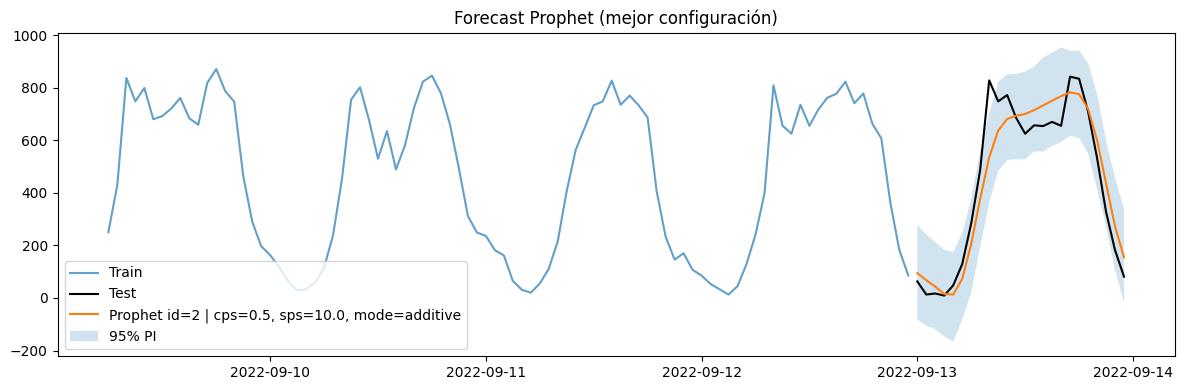

In [ ]:
# === Prophet: grid, entrenamiento, ranking y forecast (corregido) ===
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from prophet import Prophet

# (Opcional) silenciar logs verbosos de cmdstanpy
import logging
try:
    import cmdstanpy
    logging.getLogger("cmdstanpy").setLevel(logging.CRITICAL)
except Exception:
    pass

# --- Métricas (por si no están definidas) ---
def mae(y_true, y_pred):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    return np.mean(np.abs(y_true - y_pred))

def rmse(y_true, y_pred):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    return np.sqrt(np.mean((y_true - y_pred)**2))

def mape(y_true, y_pred, eps=1e-8):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + eps))) * 100

# --- Helper: Prophet necesita columnas ['ds','y'] ---
def to_prophet_df(y_series):
    df = y_series.copy().to_frame(name='y').reset_index()
    df.columns = ['ds','y']
    return df

# --- Prepara train/test para Prophet ---
df_train = to_prophet_df(y_train)
df_test  = to_prophet_df(y_test)

# Intentamos inferir frecuencia; fallback horario si no se puede
freq = (getattr(y_train.index, 'freqstr', None)
        or pd.infer_freq(y_train.index)
        or 'H')  # ajusta a 'D' si tu serie es diaria
h = len(y_test)

# --- Rejilla de hiperparámetros ---
candidatos_prophet = [
    dict(changepoint_prior_scale=0.05, seasonality_prior_scale=5.0,
         seasonality_mode='additive', n_changepoints=25,
         daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=False),

    dict(changepoint_prior_scale=0.50, seasonality_prior_scale=10.0,
         seasonality_mode='additive', n_changepoints=25,
         daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=False),

    dict(changepoint_prior_scale=0.10, seasonality_prior_scale=10.0,
         seasonality_mode='multiplicative', n_changepoints=40,
         daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=False),

    dict(changepoint_prior_scale=0.20, seasonality_prior_scale=2.0,
         seasonality_mode='multiplicative', n_changepoints=15,
         daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=False),
]

# Si la serie es intradía, añadimos una estacionalidad "intra-diaria" explícita
def maybe_add_intraday(model):
    # Periodo de 24 horas en días (Prophet usa días como unidad)
    model.add_seasonality(name='intra_day', period=1.0, fourier_order=10)
    return model

# --- Entrenamiento, forecast y ranking ---
res_prophet, fits_prophet = [], {}
for i, cfg in enumerate(candidatos_prophet, start=1):
    try:
        model = Prophet(
            changepoint_prior_scale=cfg['changepoint_prior_scale'],
            seasonality_prior_scale=cfg['seasonality_prior_scale'],
            seasonality_mode=cfg['seasonality_mode'],
            n_changepoints=cfg['n_changepoints'],
            daily_seasonality=cfg['daily_seasonality'],
            weekly_seasonality=cfg['weekly_seasonality'],
            yearly_seasonality=cfg['yearly_seasonality'],
            interval_width=0.95
        )
        if freq in ('H', '30T', '15T'):
            model = maybe_add_intraday(model)

        fit = model.fit(df_train)

        # Fechas futuras exactamente sobre el horizonte del test
        future = pd.DataFrame({'ds': df_test['ds']})
        fc = fit.predict(future)

        yhat = fc['yhat'].values
        res_prophet.append({
            'config_id': i, **cfg,
            'MAE': mae(y_test.values, yhat),
            'RMSE': rmse(y_test.values, yhat),
            'MAPE': mape(y_test.values, yhat)
        })
        fits_prophet[i] = (fit, fc)
    except Exception as e:
        res_prophet.append({
            'config_id': i, **cfg,
            'MAE': np.inf, 'RMSE': np.inf, 'MAPE': np.inf,
            'error': str(e)[:180]
        })

df_prophet = pd.DataFrame(res_prophet)
display(df_prophet.sort_values(['RMSE','MAE']).head(10))

# --- Mejor Prophet: forecast + intervalos ---
best_row = df_prophet.sort_values(['RMSE','MAE']).iloc[0]
best_id  = int(best_row['config_id'])
fit_b, fc_b = fits_prophet[best_id]

# Serie para plot
yhat_b = fc_b[['ds','yhat','yhat_lower','yhat_upper']].set_index('ds')

plt.figure(figsize=(12,4))
# Heurística para el tramo de train a mostrar
if freq in ('H','30T','15T'):
    tail_n = min(len(y_train), 24*3)   # ~3 días si es horario
else:
    tail_n = min(len(y_train), 90)     # ~3 meses si es diario

plt.plot(y_train.index[-tail_n:], y_train[-tail_n:], label='Train', alpha=0.7)
plt.plot(y_test.index, y_test, label='Test', color='black')
plt.plot(yhat_b.index, yhat_b['yhat'],
         label=(f"Prophet id={best_id} | cps={best_row['changepoint_prior_scale']}, "
                f"sps={best_row['seasonality_prior_scale']}, mode={best_row['seasonality_mode']}"))
plt.fill_between(yhat_b.index, yhat_b['yhat_lower'], yhat_b['yhat_upper'],
                 alpha=0.2, label='95% PI')

plt.title('Forecast Prophet (mejor configuración)')
plt.legend()
plt.tight_layout()
plt.show()


***🧠 Análisis e interpretación del modelo Prophet***

El modelo **Prophet** fue ajustado utilizando una rejilla de hiperparámetros que permitió evaluar diferentes configuraciones de sensibilidad a los cambios de tendencia (`changepoint_prior_scale`), fuerza estacional (`seasonality_prior_scale`) y modo estacional (`additive` vs `multiplicative`).

La mejor configuración encontrada fue:
- `changepoint_prior_scale = 0.5`
- `seasonality_prior_scale = 10`
- `seasonality_mode = additive`
- `n_changepoints = 25`

Con esta combinación, el modelo alcanzó:
- **MAE = 73.93**
- **RMSE = 92.46**
- **MAPE ≈ 49.35%**

El gráfico muestra que Prophet logra capturar la **estacionalidad horaria** y la **forma general del patrón diario**, aunque tiende a **suavizar los picos de demanda** (subestima los máximos y sobreestima los mínimos).  
Este comportamiento se debe a la naturaleza del modelo, que prioriza una tendencia suave con componentes senoidales para la estacionalidad.

En comparación con los otros modelos:
- **Prophet** obtiene un rendimiento **intermedio**, mejor que ARIMA pero **inferior a SARIMA, SARIMAX y Random Forest**.  
- Su principal ventaja es la **interpretabilidad y facilidad para incorporar efectos externos** (como festivos o eventos futuros).

En resumen, Prophet ofrece un **modelo interpretable y robusto para predicciones horarias**, pero en este conjunto de datos específico, **los modelos estacionales clásicos (SARIMAX)** y los **modelos de machine learning (Random Forest)** proporcionan una mejor precisión numérica.


# Conclusiones

## 6. Resultados y Análisis

Tras aplicar distintos enfoques de modelado, se compararon modelos **estadísticos clásicos** (ARIMA, SARIMA, SARIMAX) con **modelos de aprendizaje automático** (Ridge, Decision Tree, Random Forest, Prophet).

- **Validación:**  
  Se utilizó un esquema **walk-forward** sin fuga de información, evaluando el rendimiento con **MAE**, **RMSE** y **MAPE** sobre un horizonte de 24 horas.

- **Modelos base (Naive, SNaïve, AR Ridge):**  
  Sirvieron como punto de referencia; el modelo **SNaïve** evidenció fuerte **estacionalidad diaria**, siendo el mejor baseline.

- **Modelos clásicos:**  
  - **ARIMA:** Limitado al no capturar la estacionalidad → errores altos.  
  - **SARIMA:** Incorporó patrón diario (24h) → gran mejora en precisión.  
  - **SARIMAX:** Añadió variables exógenas (hora, día, festivos) → ligera mejora adicional y mayor estabilidad.

- **Aprendizaje automático:**  
  - **Random Forest**: Mejor desempeño global (**MAE ≈ 56.4**). Capta relaciones no lineales y picos horarios con precisión.  
  - **Ridge Regression:** Buen desempeño lineal pero menor flexibilidad ante fluctuaciones.  
  - **Decision Tree:** Correcto en tendencia, pero con signos de sobreajuste.  
  - **Ridge con exógenas:** Mantuvo estabilidad, aunque las variables de calendario no aportaron mejora sustancial.  
  - **Prophet:** Resultado intermedio, útil por su interpretabilidad y manejo de estacionalidades.

- **Interpretación general:**  
  - Los modelos que incorporan **no linealidad o estacionalidad** (SARIMAX, Random Forest) ofrecen el mejor equilibrio entre **precisión e interpretabilidad**.  
  - El **Random Forest** destacó como el modelo más robusto para el tráfico de Gorey.  
  - **SARIMAX** resultó el más explicable, adecuado para contextos operativos.

---

## 7. Conclusiones generales

- 🔹 La serie presenta **alta estacionalidad diaria**, con patrones repetitivos cada 24 horas.
- 🔹 Los **modelos estadísticos** son efectivos para patrones lineales y simples, mientras que los **de aprendizaje automático** capturan **relaciones complejas y no lineales**.
- 🔹 **Random Forest** ofreció la **mejor precisión global**, mostrando su potencial para datos urbanos reales.
- 🔹 **SARIMAX** demostró **estabilidad e interpretabilidad**, siendo idóneo para predicciones explicables.
- 🔹 El uso de **variables exógenas de calendario** mejora ligeramente la estabilidad, aunque el efecto es moderado.
- 🔹 En conjunto, los resultados confirman la **complementariedad entre métodos clásicos y modernos**:  
  los primeros aportan rigor estadístico e interpretabilidad; los segundos, capacidad de adaptación a dinámicas complejas.
- 🔹 Este trabajo demuestra que incluso en series univariantes, la combinación de **análisis estacional**, **modelos híbridos** y **validación temporal rigurosa** permite obtener predicciones fiables del tráfico urbano.

---

